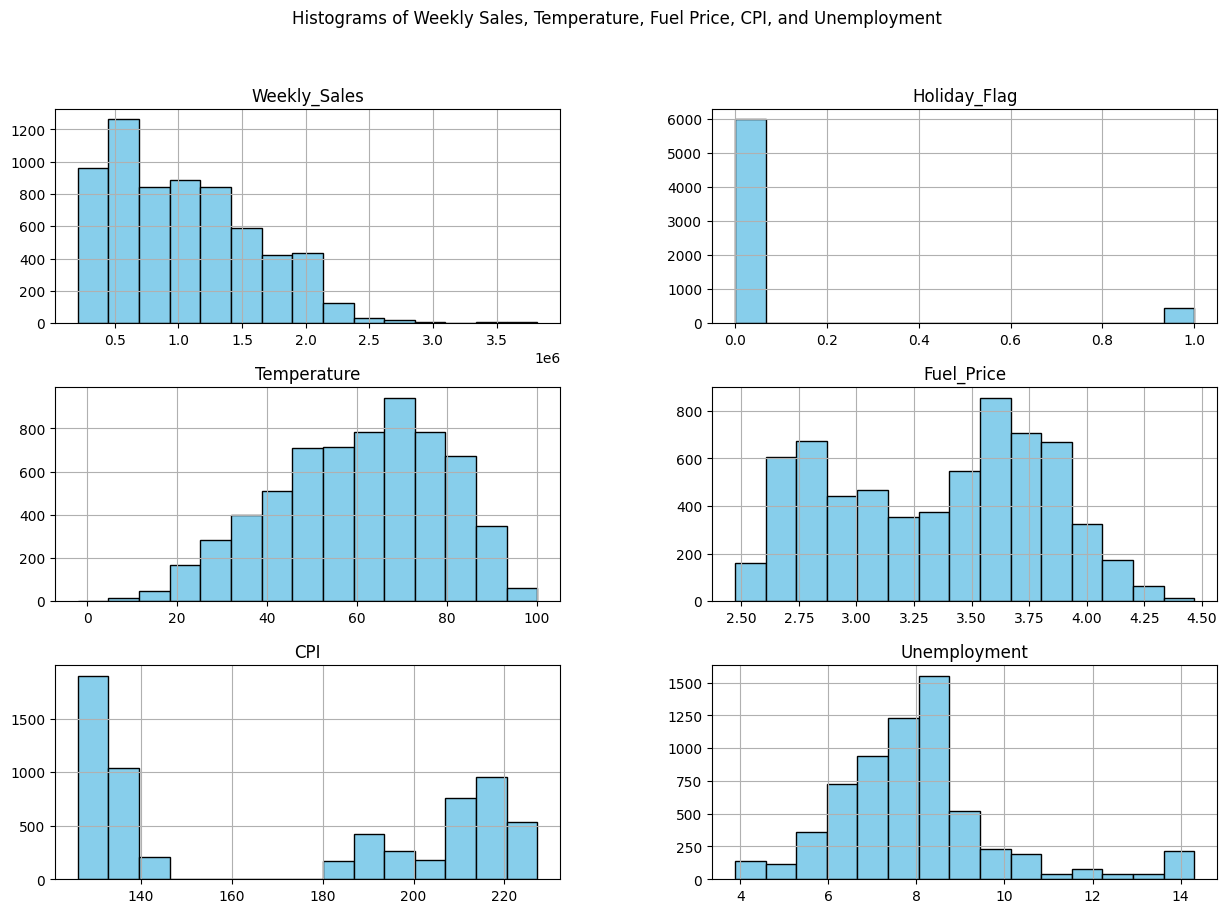

In [ ]:
# Create histograms for each variable
df[columns_of_interest].hist(bins=15, figsize=(15, 10), color='skyblue', edgecolor='black')
plt.suptitle('Histograms of Weekly Sales, Temperature, Fuel Price, CPI, and Unemployment')
plt.show()

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder

# Upload the CSV file
uploaded = files.upload()

# Read the CSV file into a DataFrame
df = pd.read_csv(next(iter(uploaded)))

# Display the first few rows to confirm it's read correctly
print(df.head())




Saving Walmart Data Analysis and Forcasting.csv to Walmart Data Analysis and Forcasting (3).csv
   Store        Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
0      1  05-02-2010    1643690.90             0        42.31       2.572   
1      1  12-02-2010    1641957.44             1        38.51       2.548   
2      1  19-02-2010    1611968.17             0        39.93       2.514   
3      1  26-02-2010    1409727.59             0        46.63       2.561   
4      1  05-03-2010    1554806.68             0        46.50       2.625   

          CPI  Unemployment  
0  211.096358         8.106  
1  211.242170         8.106  
2  211.289143         8.106  
3  211.319643         8.106  
4  211.350143         8.106  


Consolidated Correlation Matrix:
              Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price       CPI  \
Weekly_Sales      1.000000      0.036891    -0.063810    0.009464 -0.072634   
Holiday_Flag      0.036891      1.000000    -0.155091   -0.078347 -0.002162   
Temperature      -0.063810     -0.155091     1.000000    0.144982  0.176888   
Fuel_Price        0.009464     -0.078347     0.144982    1.000000 -0.170642   
CPI              -0.072634     -0.002162     0.176888   -0.170642  1.000000   
Unemployment     -0.106176      0.010960     0.101158   -0.034684 -0.302020   

              Unemployment  
Weekly_Sales     -0.106176  
Holiday_Flag      0.010960  
Temperature       0.101158  
Fuel_Price       -0.034684  
CPI              -0.302020  
Unemployment      1.000000  


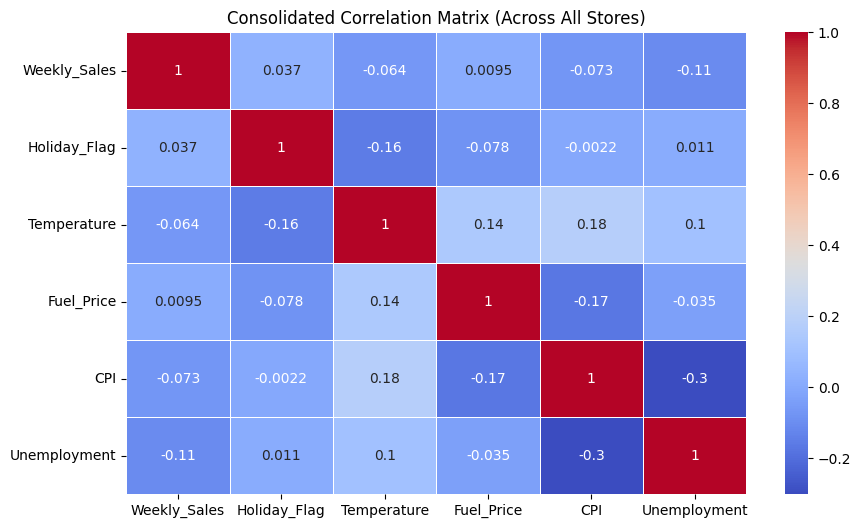

In [3]:
# Select only the relevant columns for the correlation matrix
columns_of_interest = ['Weekly_Sales', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
correlation_df = df[columns_of_interest]

# Calculate the consolidated correlation matrix across all stores
consolidated_correlation_matrix = correlation_df.corr()

# Print the consolidated correlation matrix
print("Consolidated Correlation Matrix:")
print(consolidated_correlation_matrix)

# Visualize the consolidated correlation matrix using a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(consolidated_correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Consolidated Correlation Matrix (Across All Stores)")
plt.show()


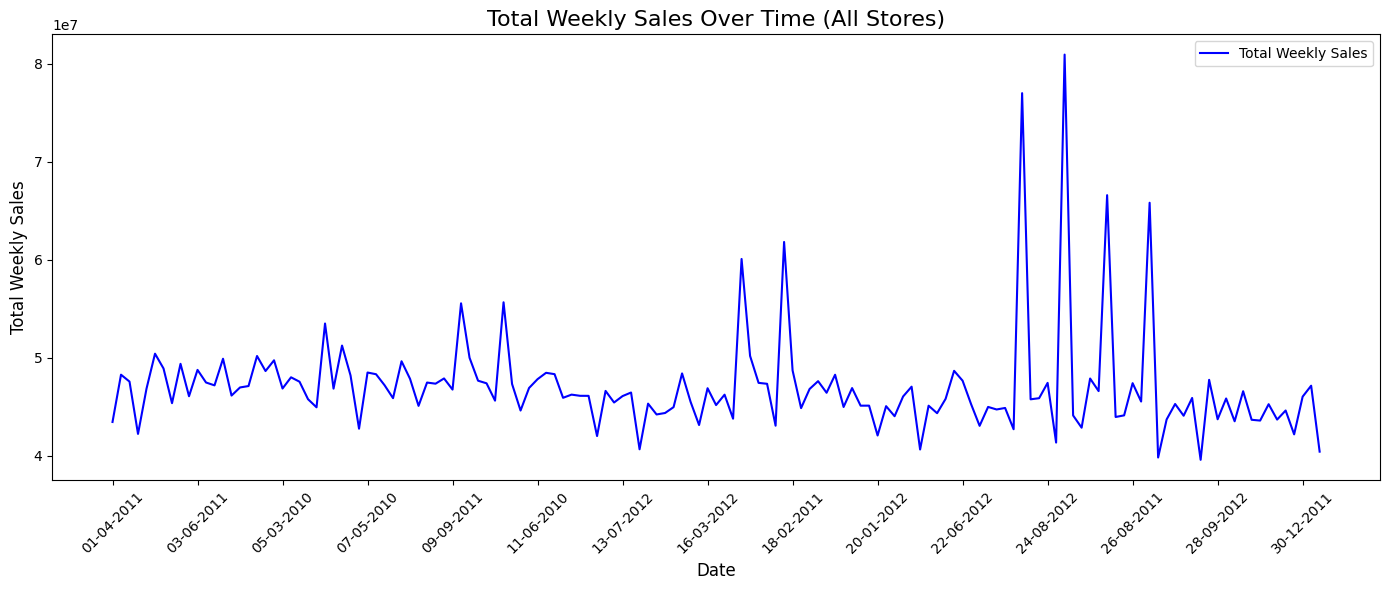

In [4]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np

# Aggregate weekly sales across all stores by summing
total_sales = df.groupby('Date')['Weekly_Sales'].sum().reset_index()

# Plotting the Total Weekly Sales over Time
plt.figure(figsize=(14, 6))  # Adjust the figure size for better readability

# Plot the total sales data
plt.plot(total_sales['Date'], total_sales['Weekly_Sales'], color='blue', label='Total Weekly Sales')

# Customize the x-axis to display fewer ticks (show every 10th date)
plt.xticks(ticks=np.arange(0, len(total_sales['Date']), step=10), rotation=45)

# Set labels and title
plt.title('Total Weekly Sales Over Time (All Stores)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Weekly Sales', fontsize=12)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


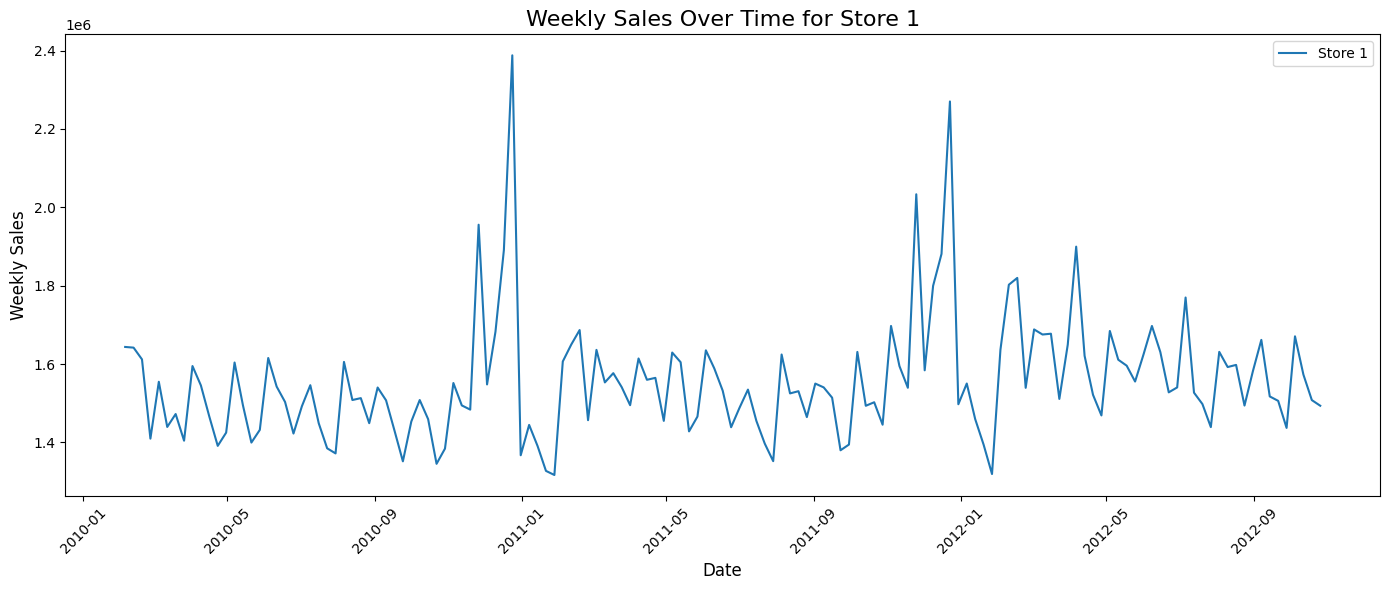

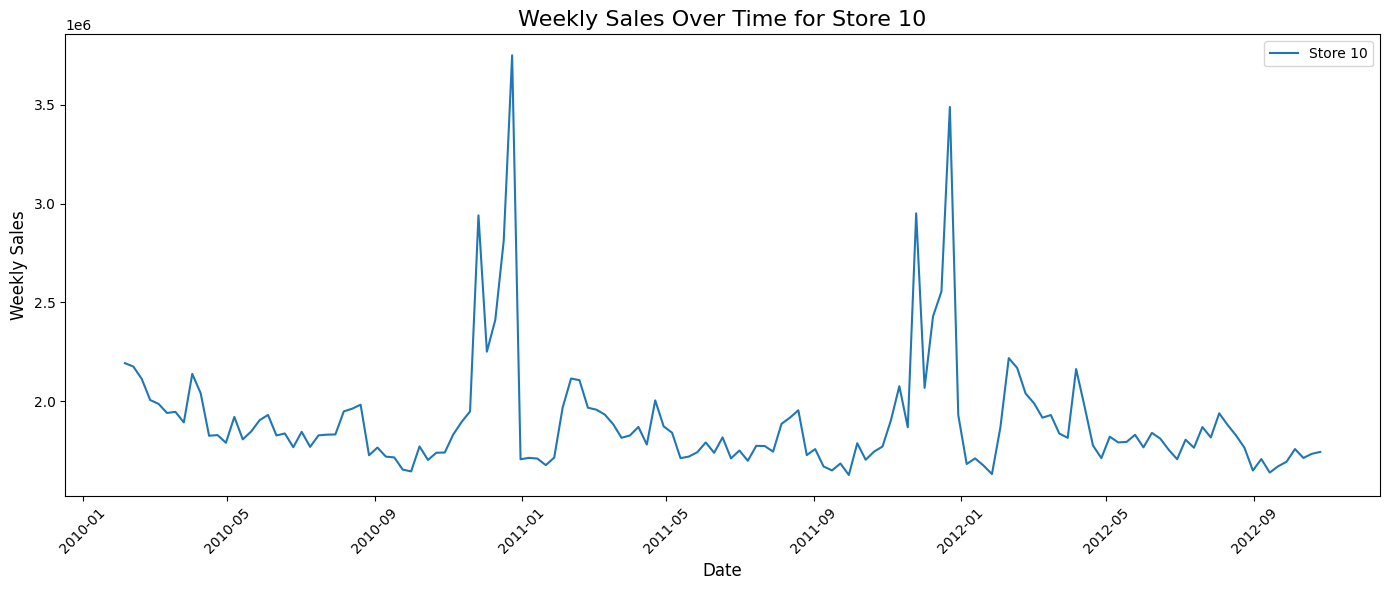

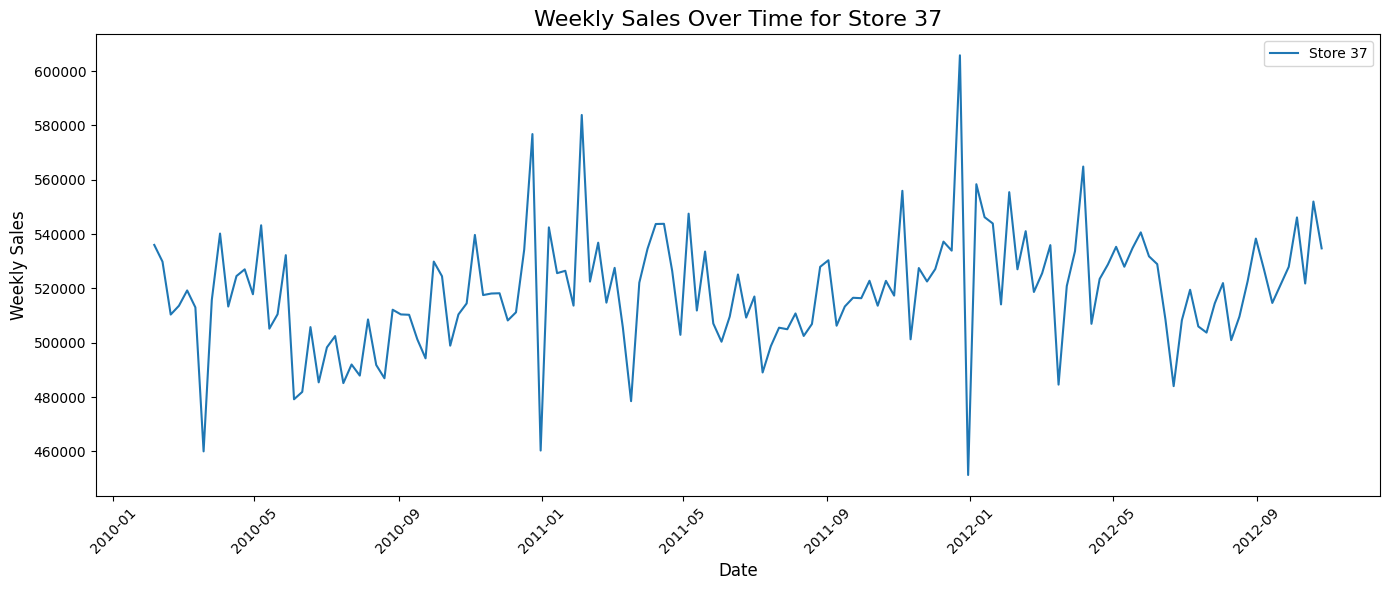

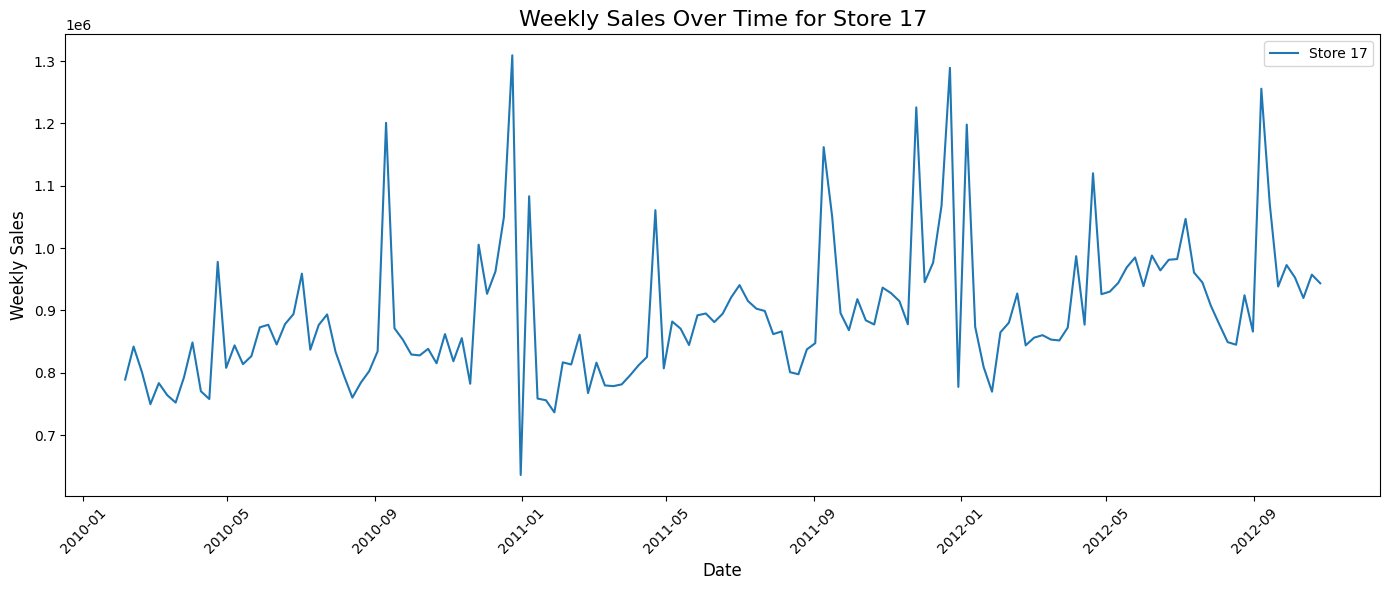

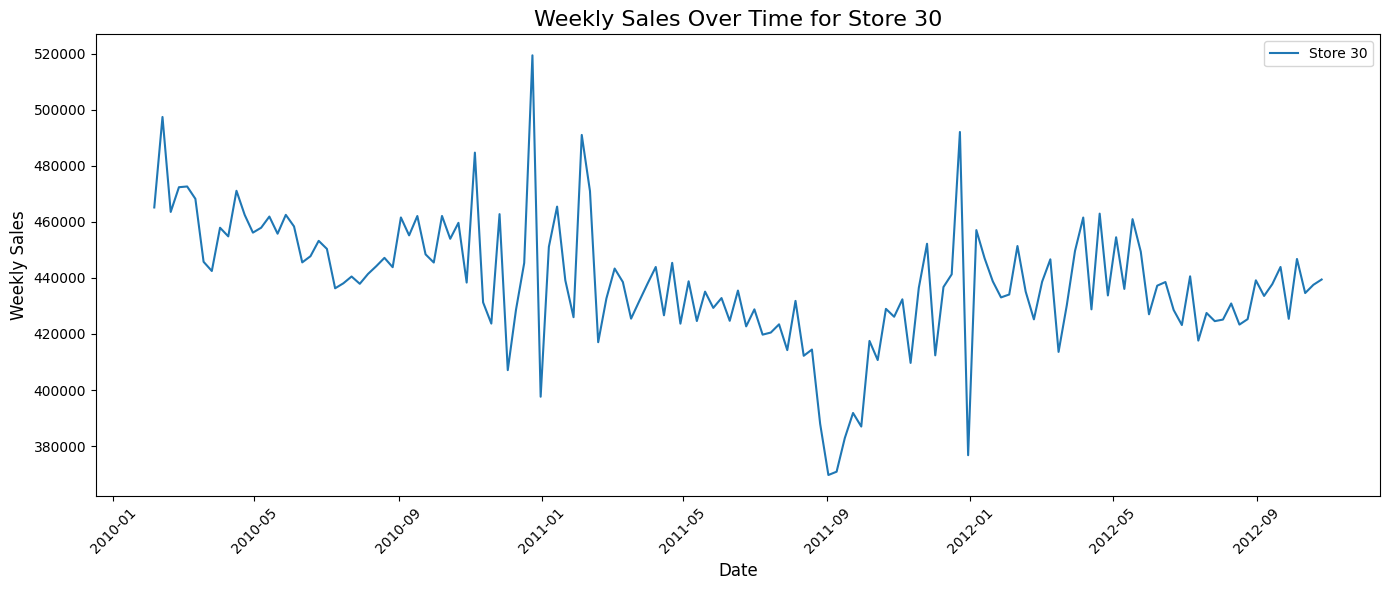

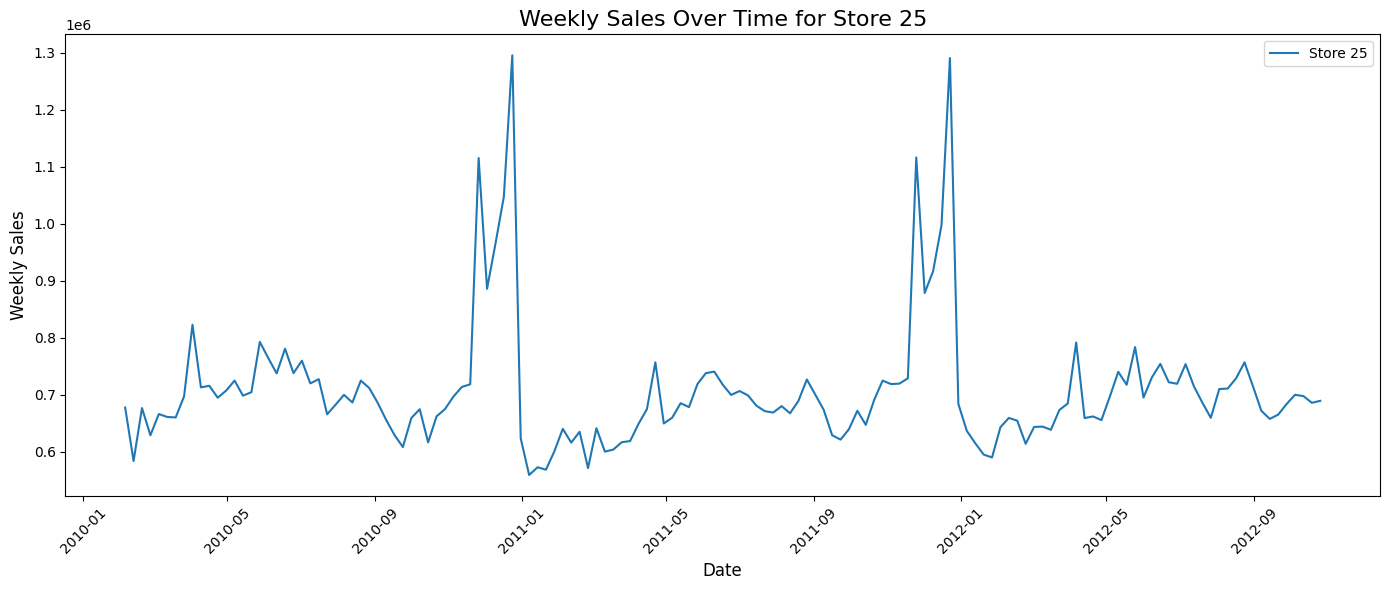

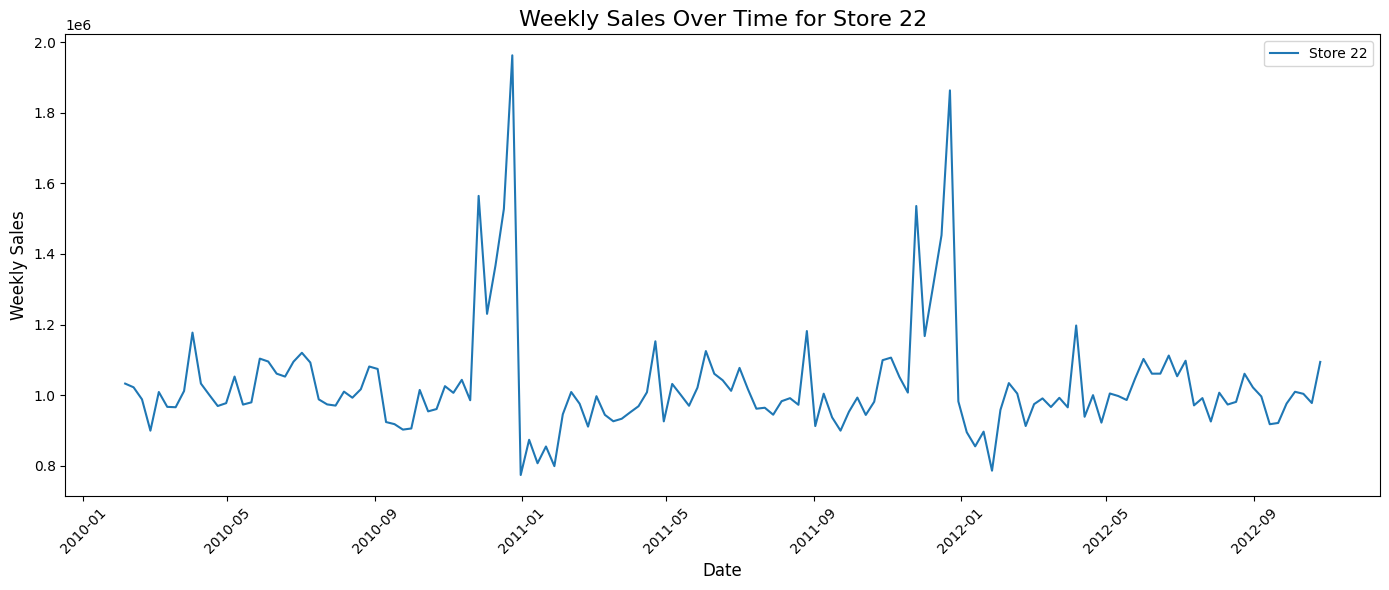

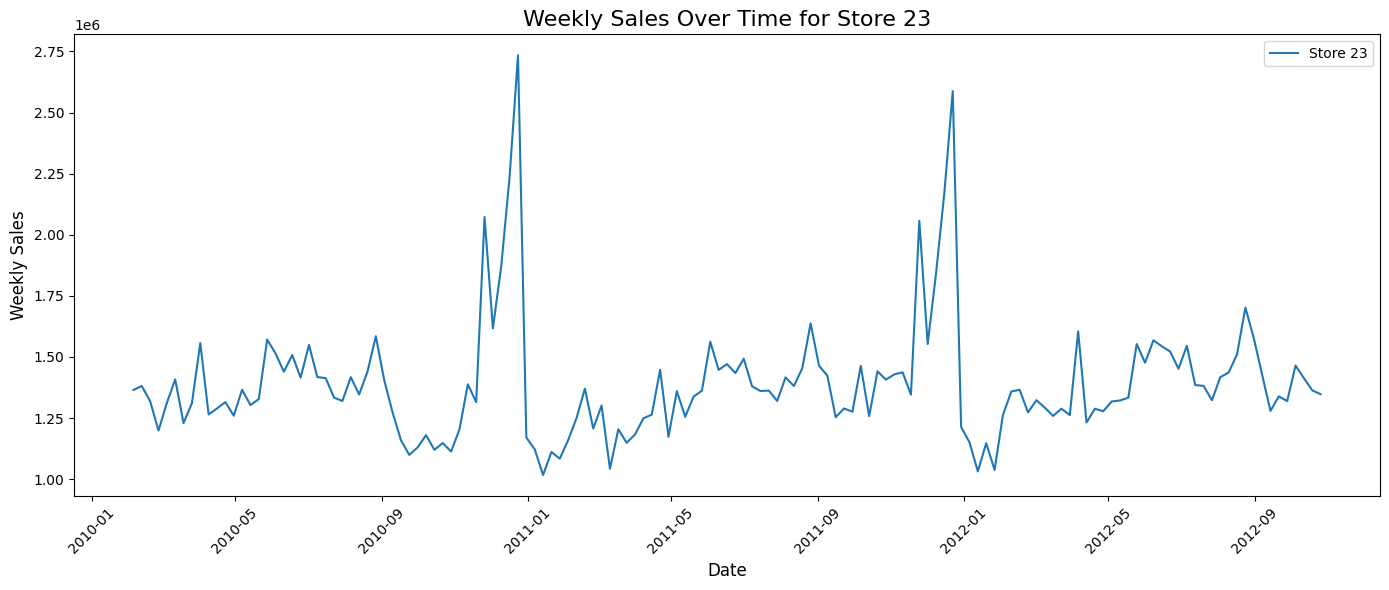

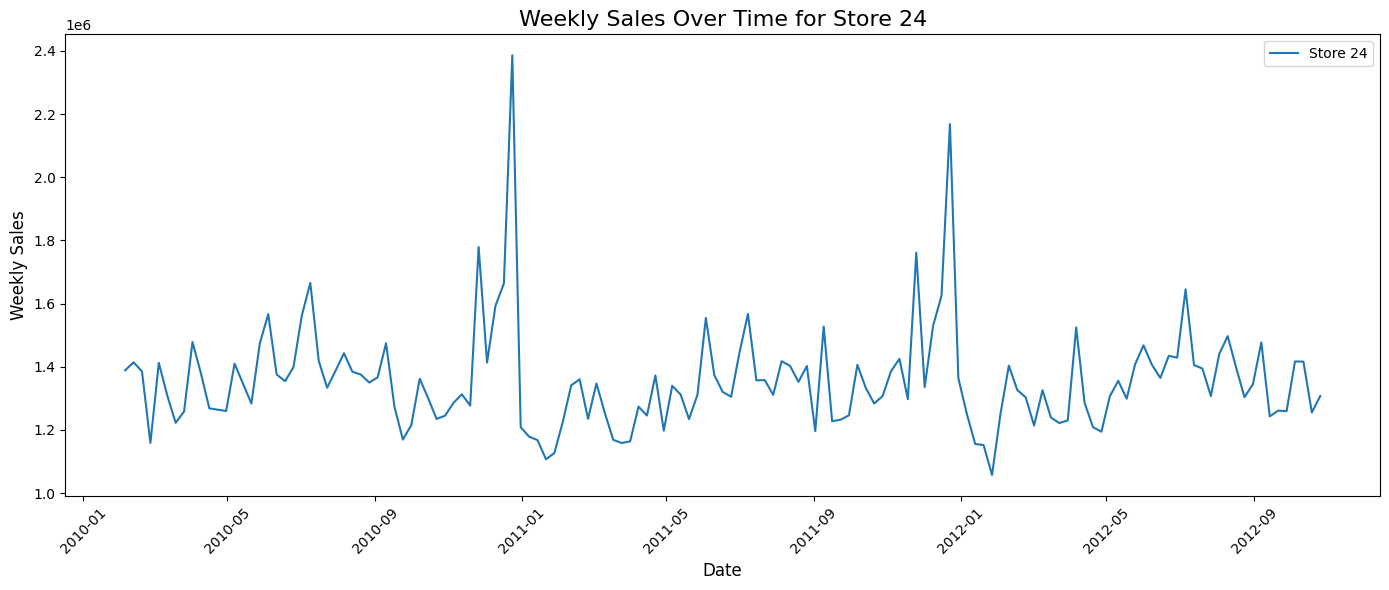

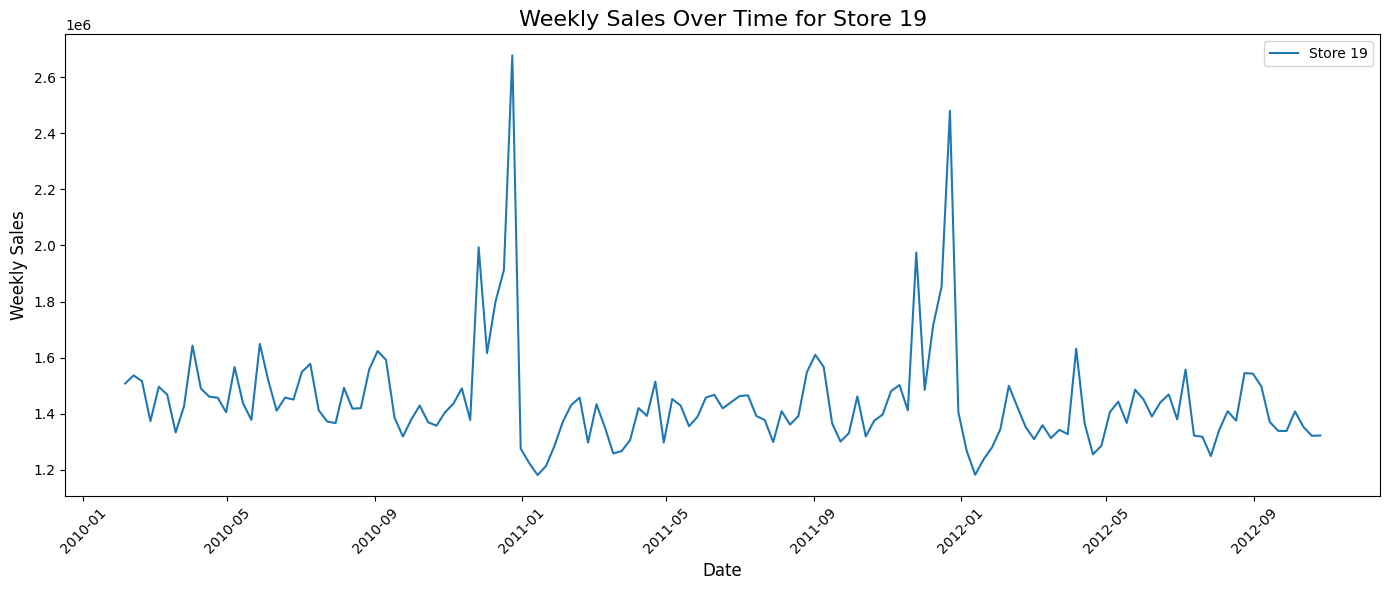

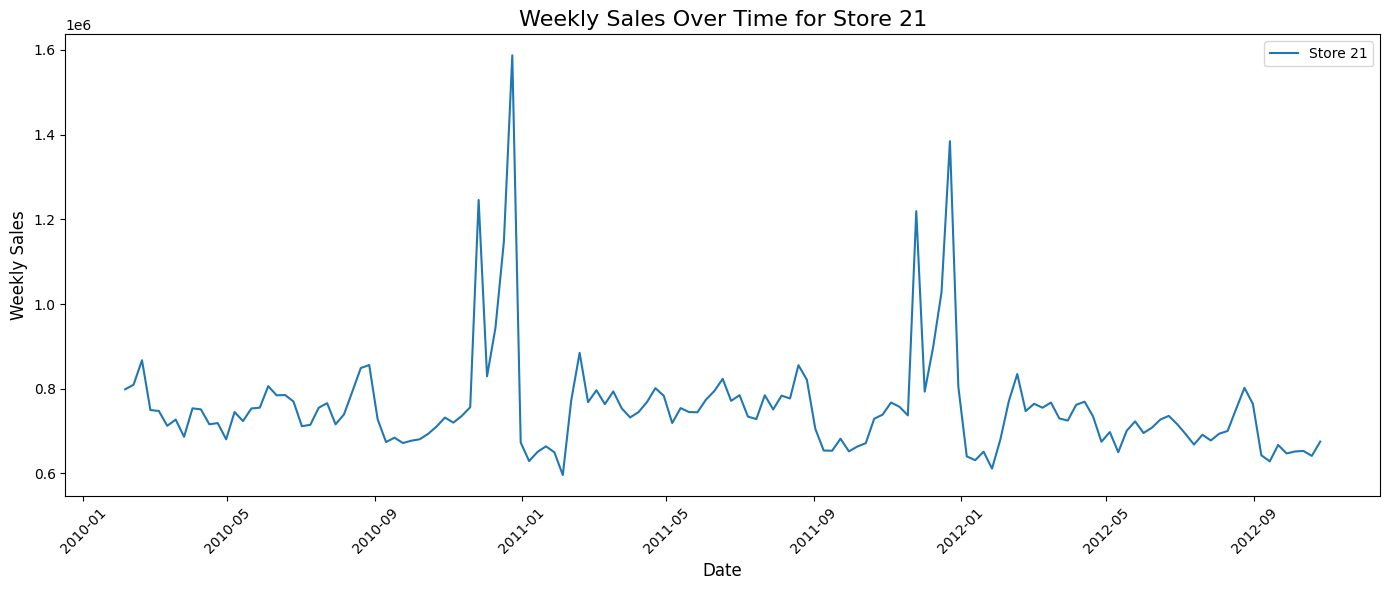

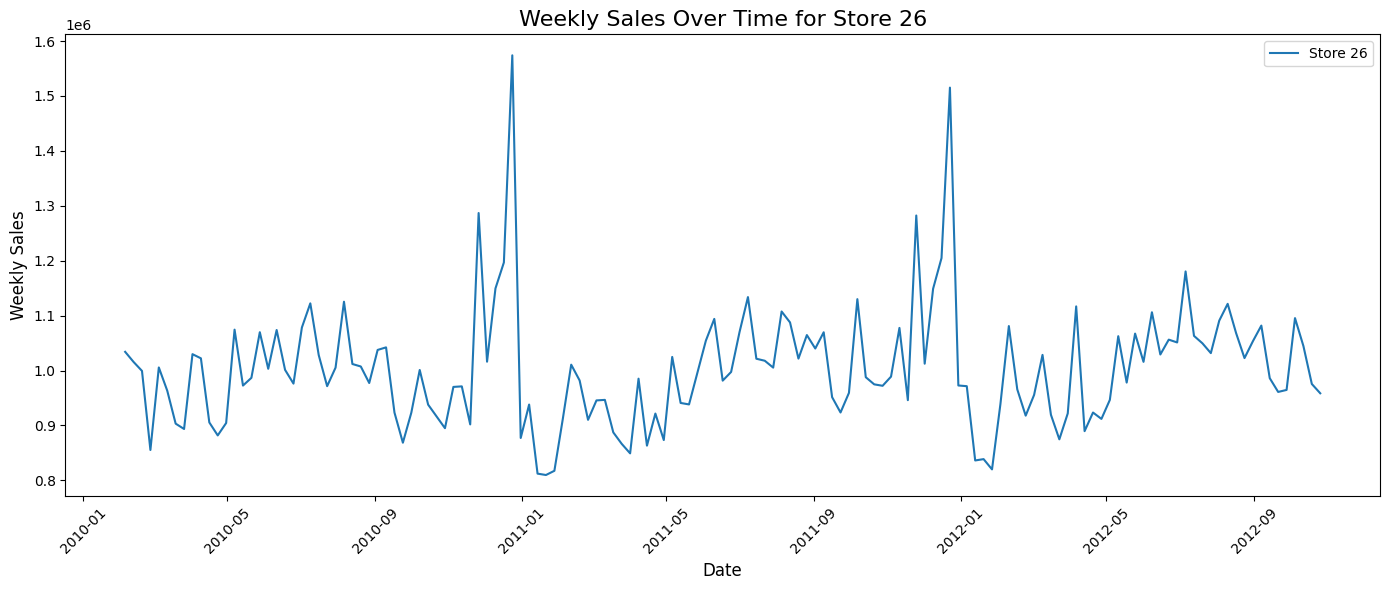

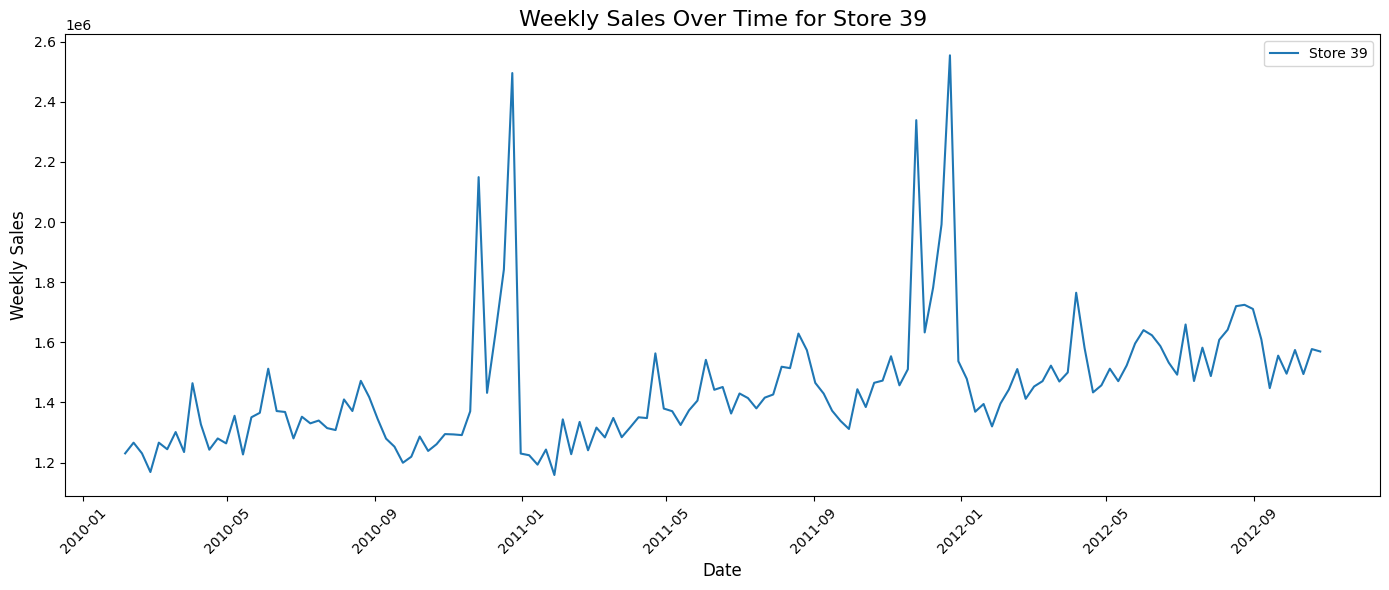

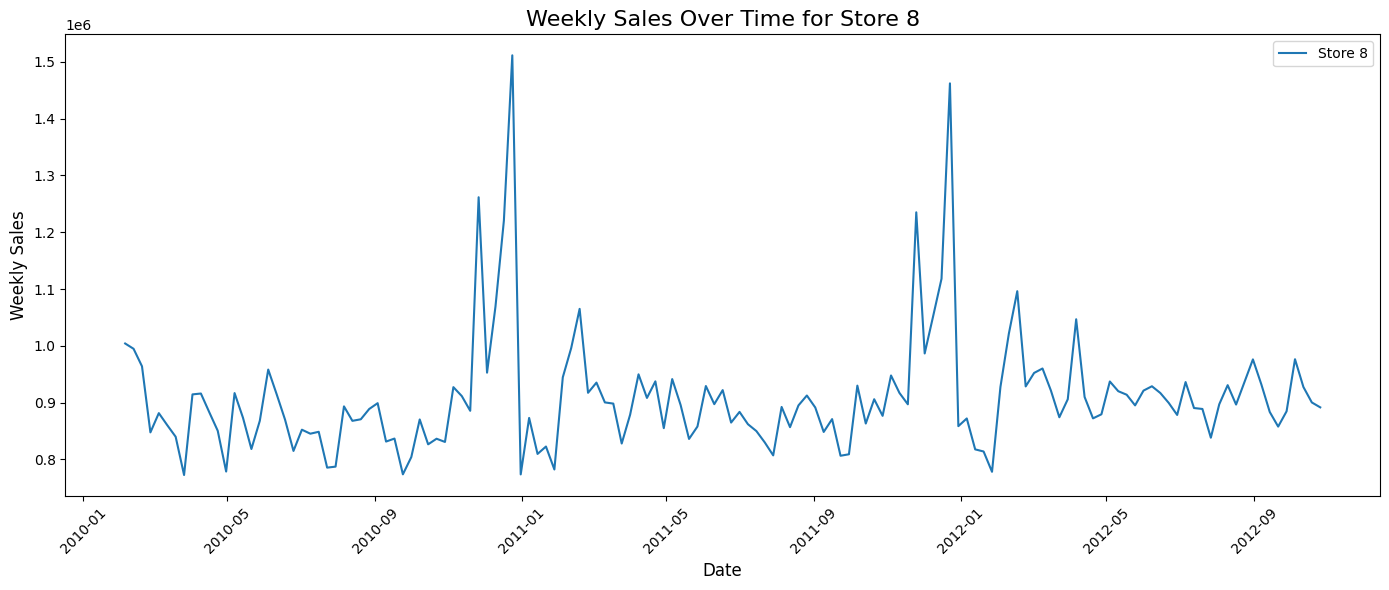

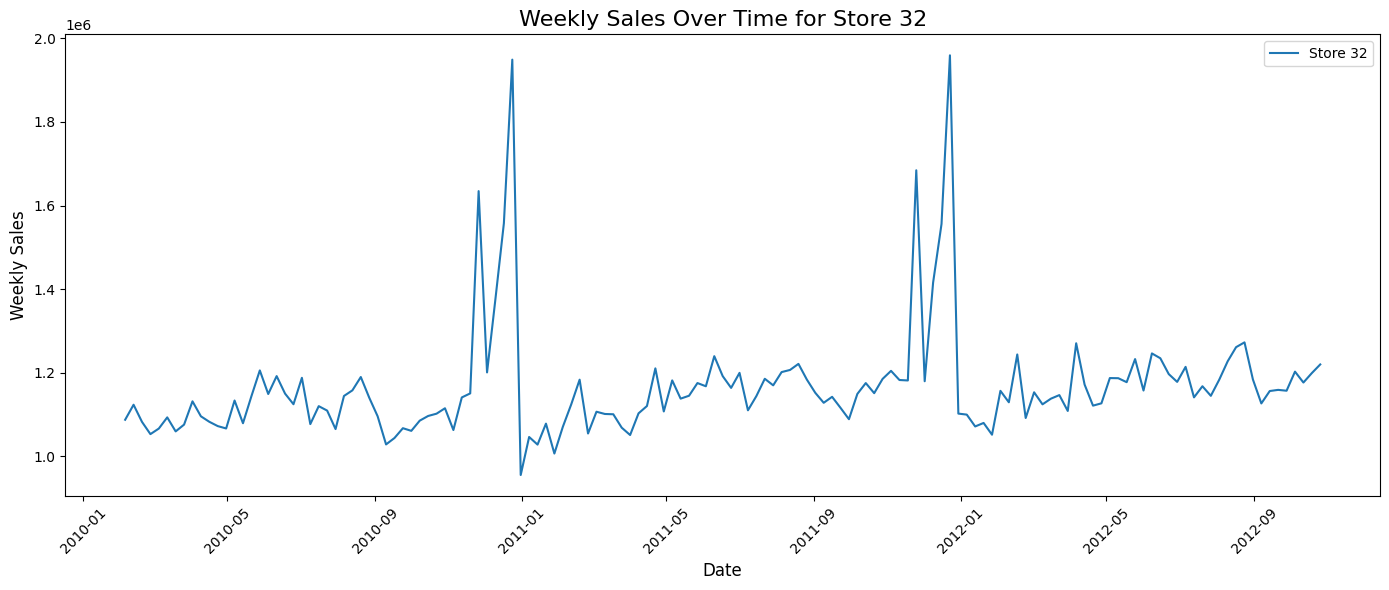

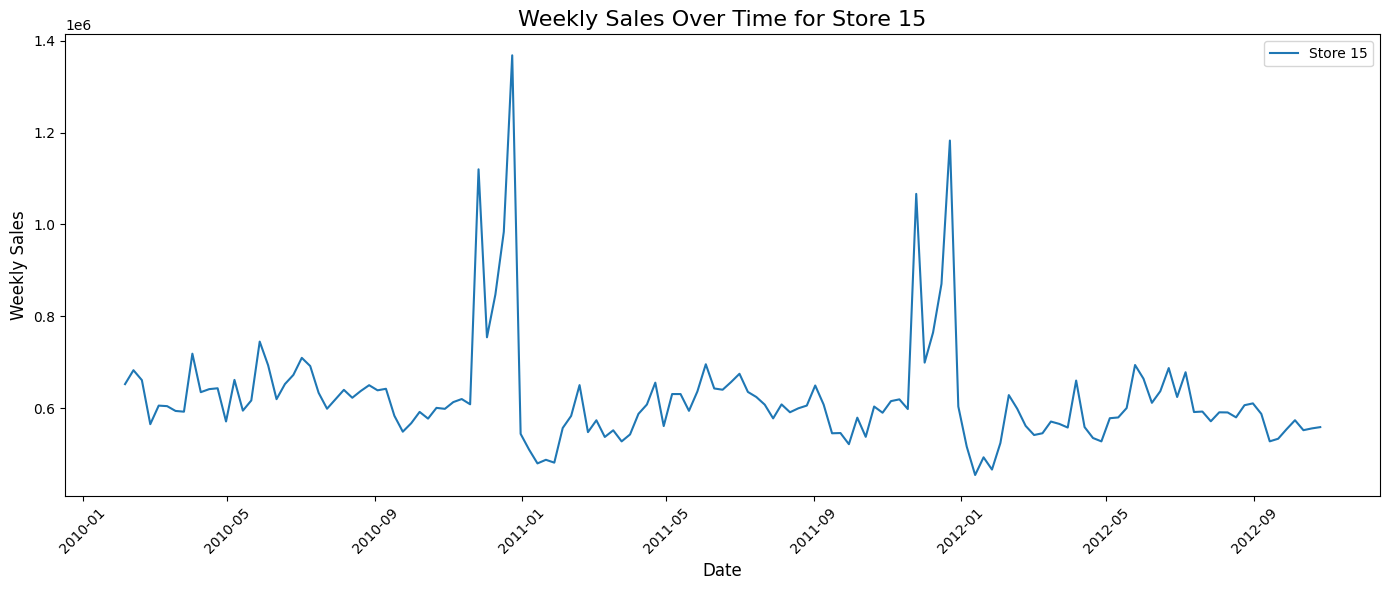

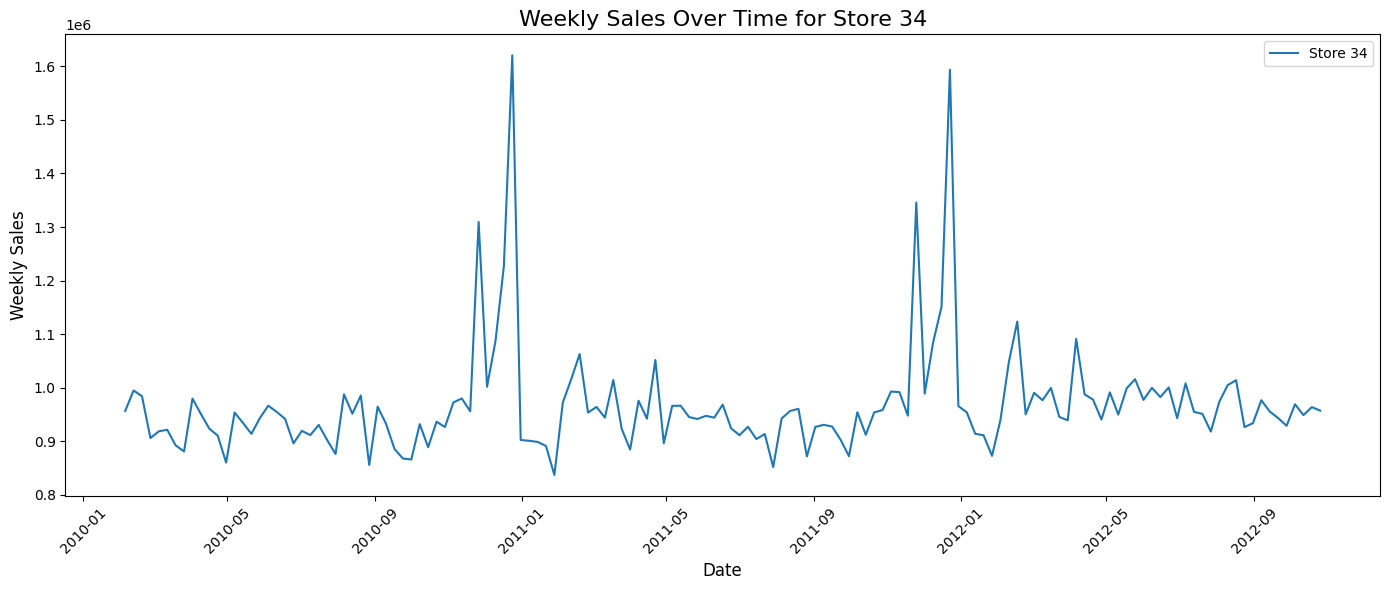

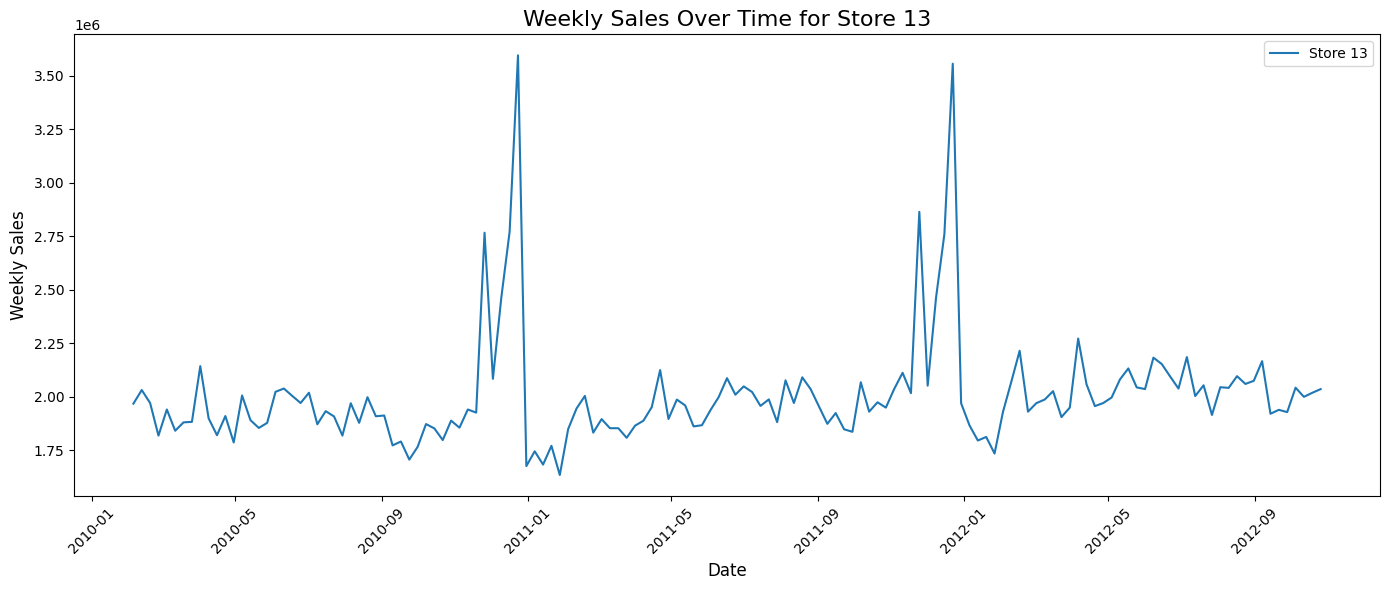

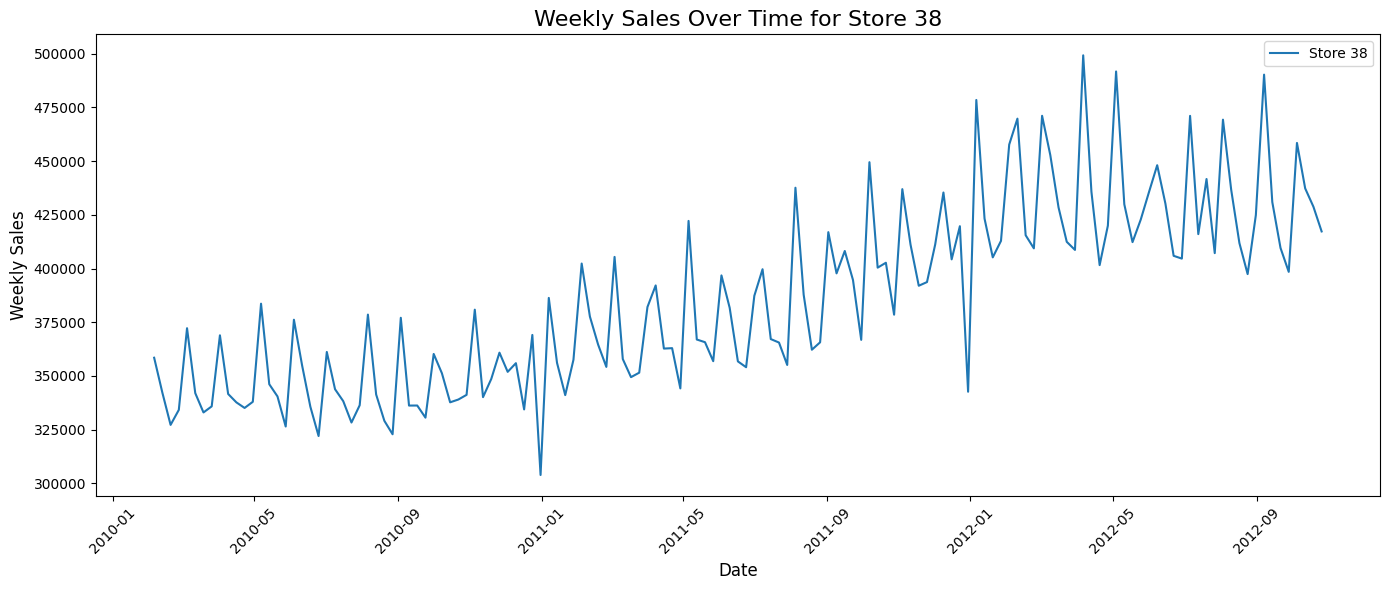

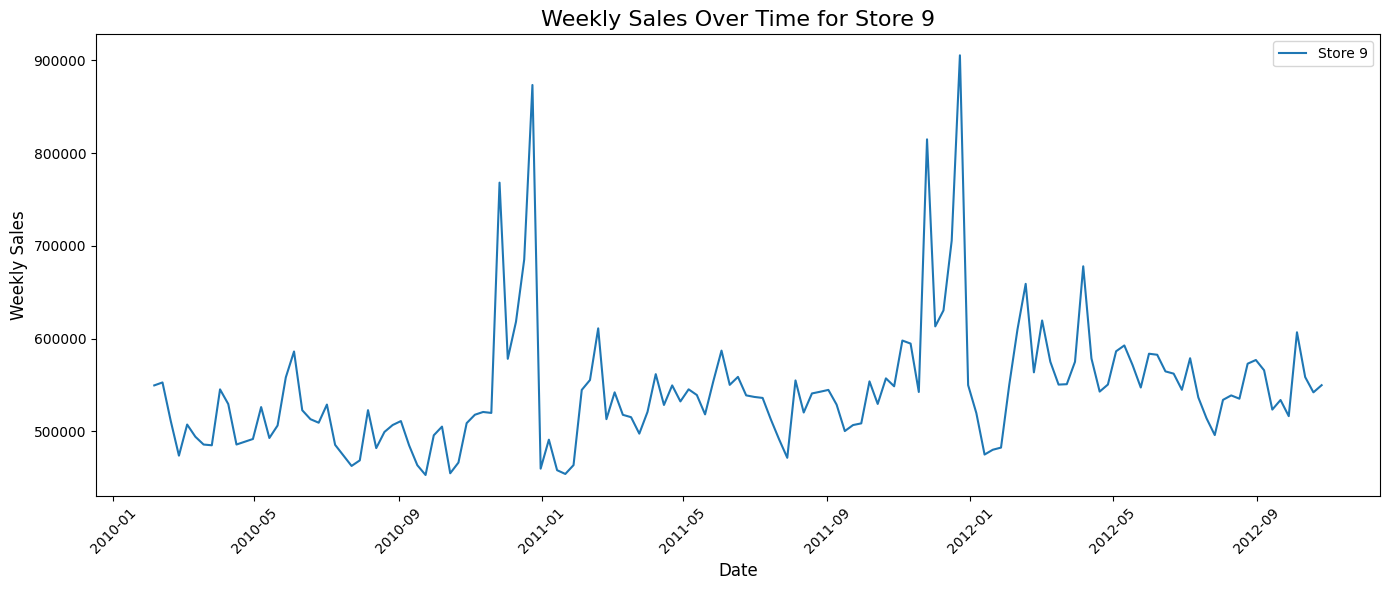

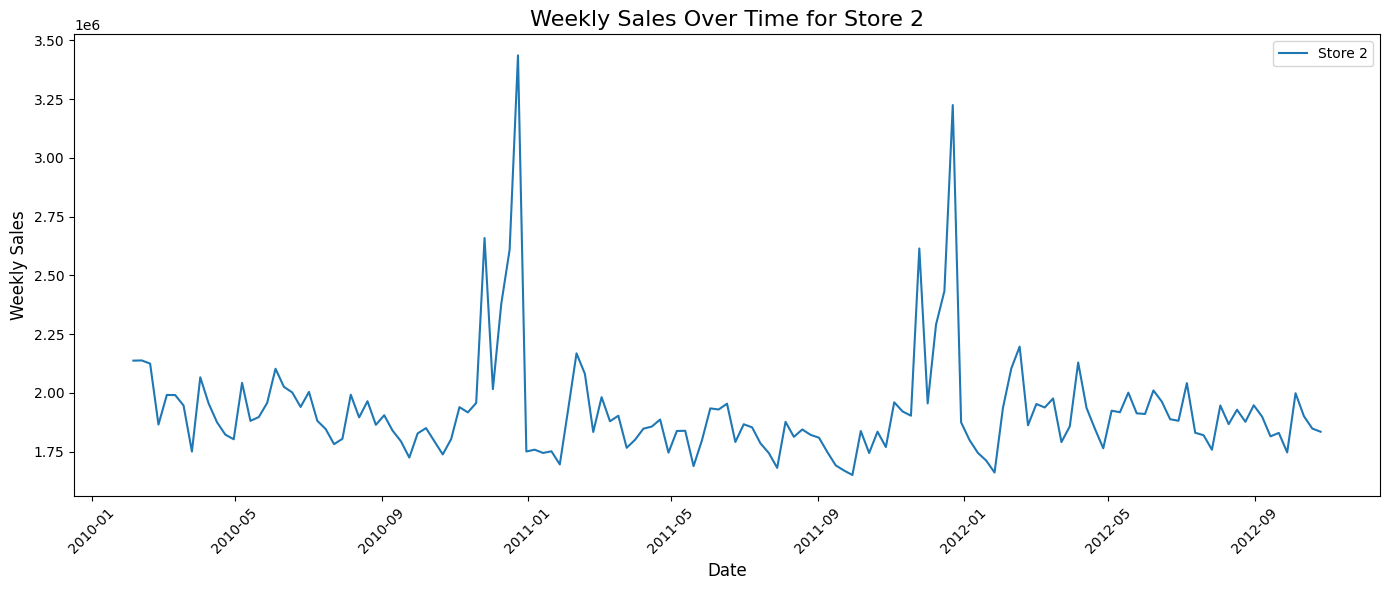

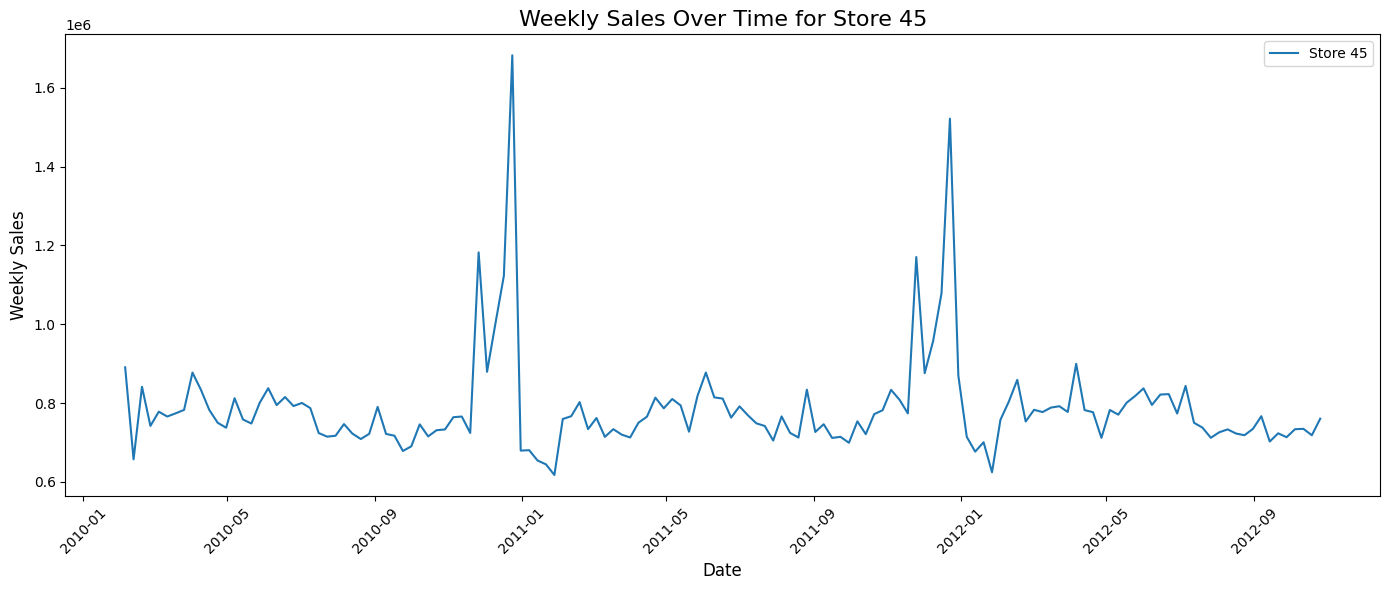

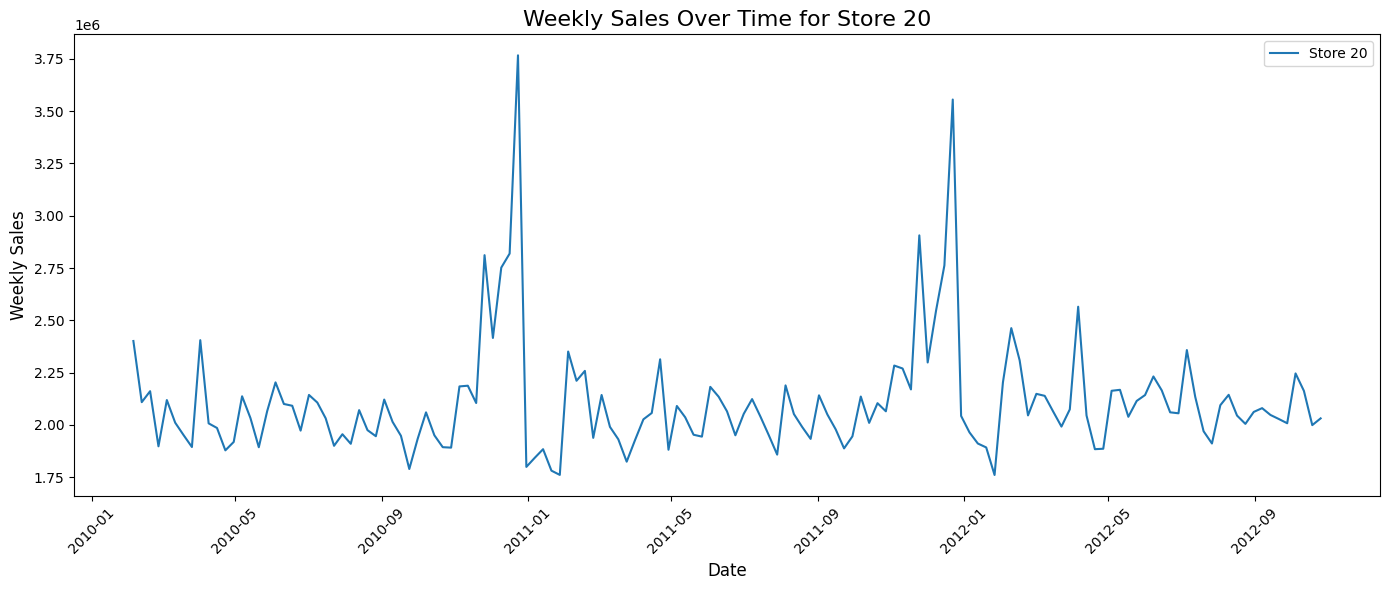

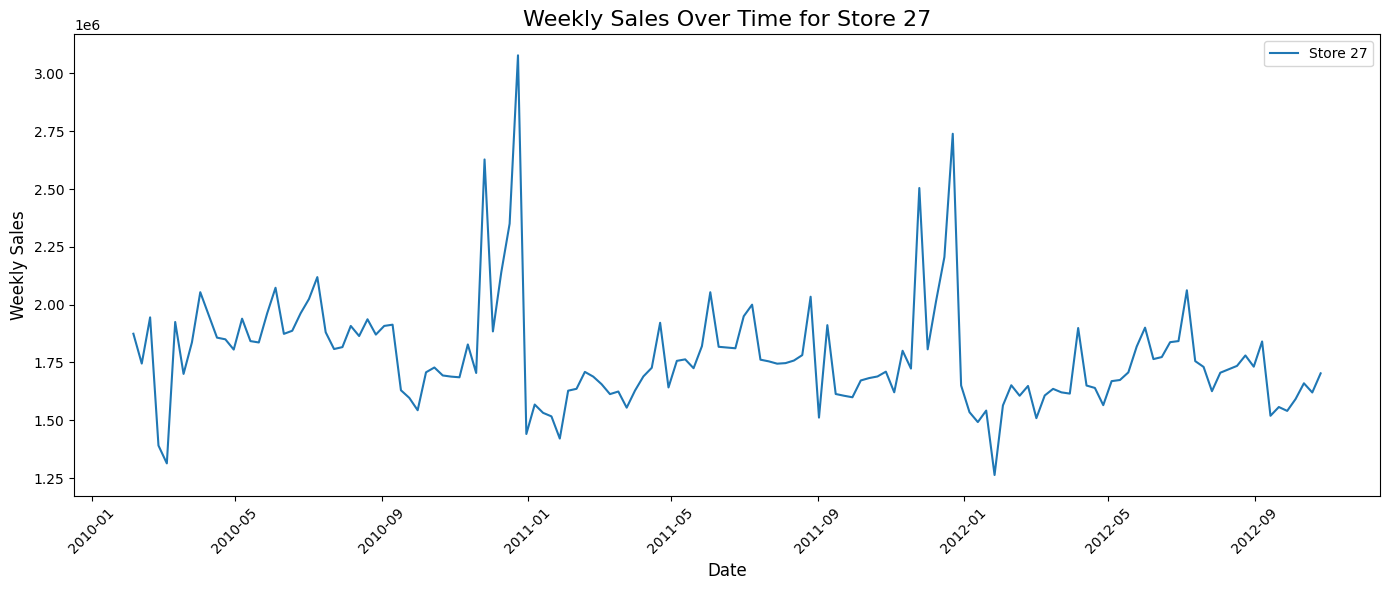

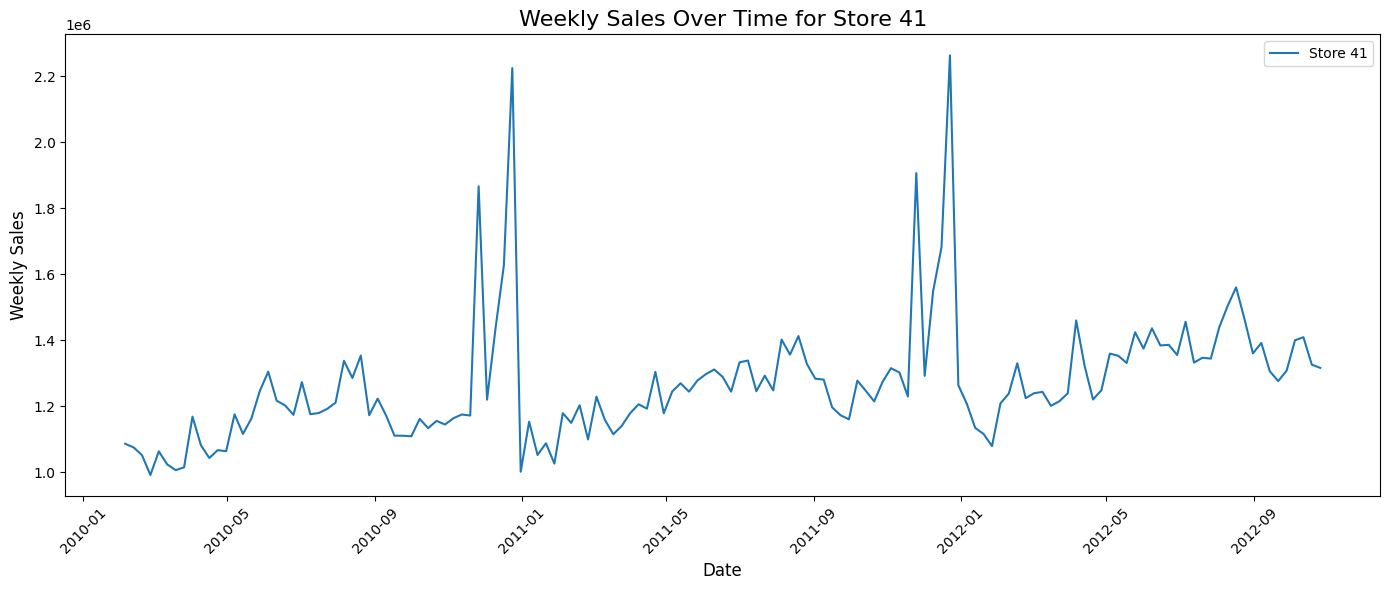

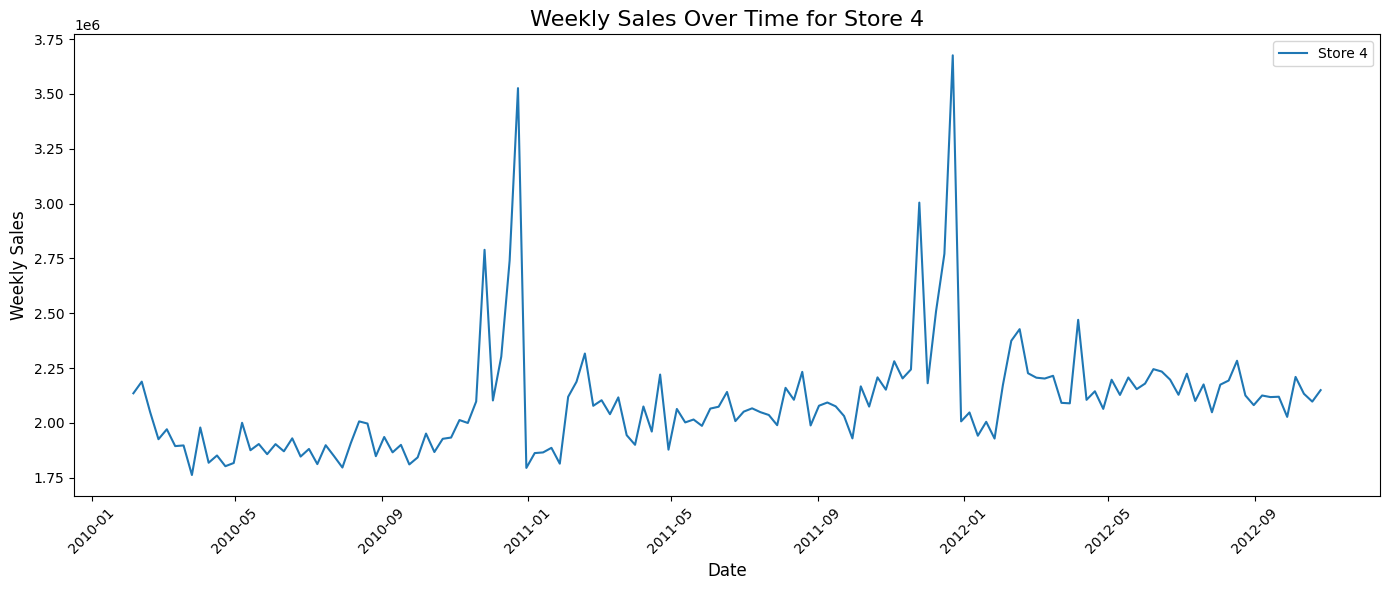

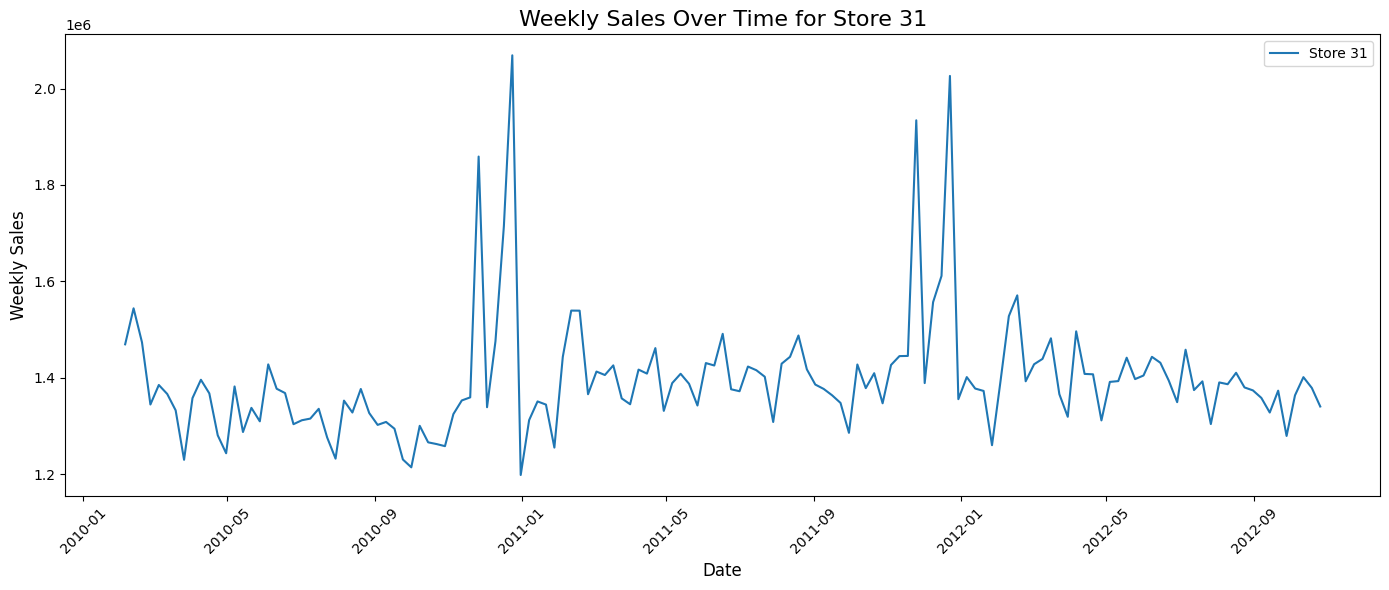

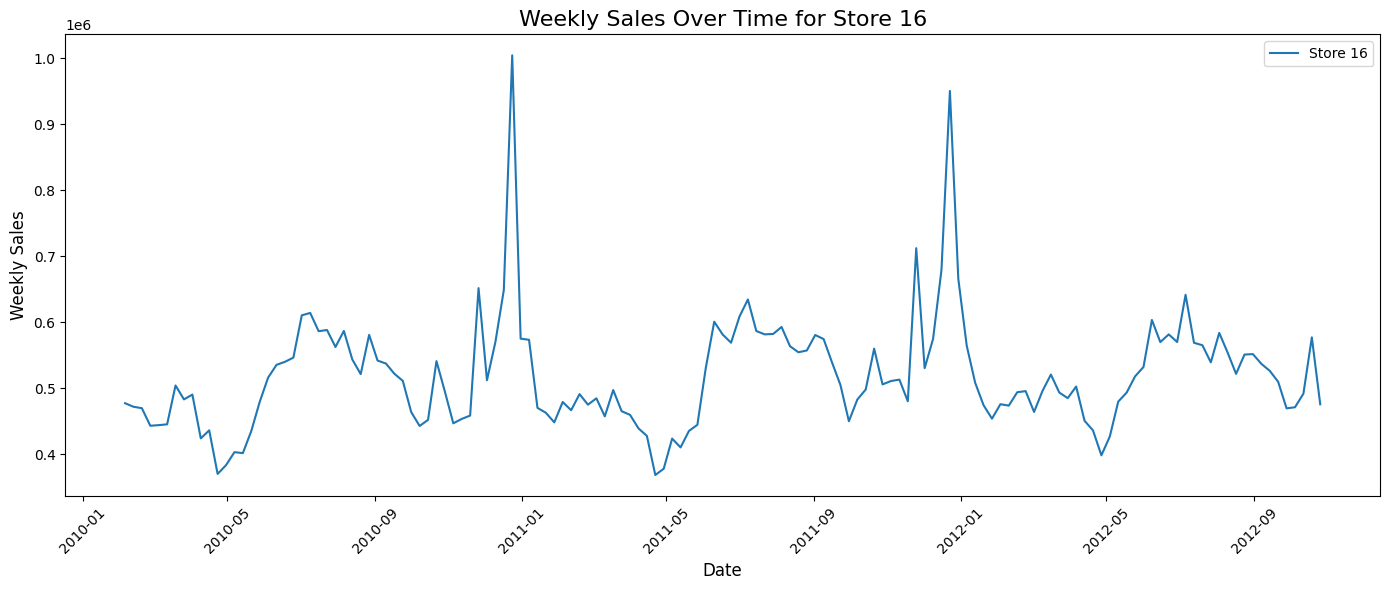

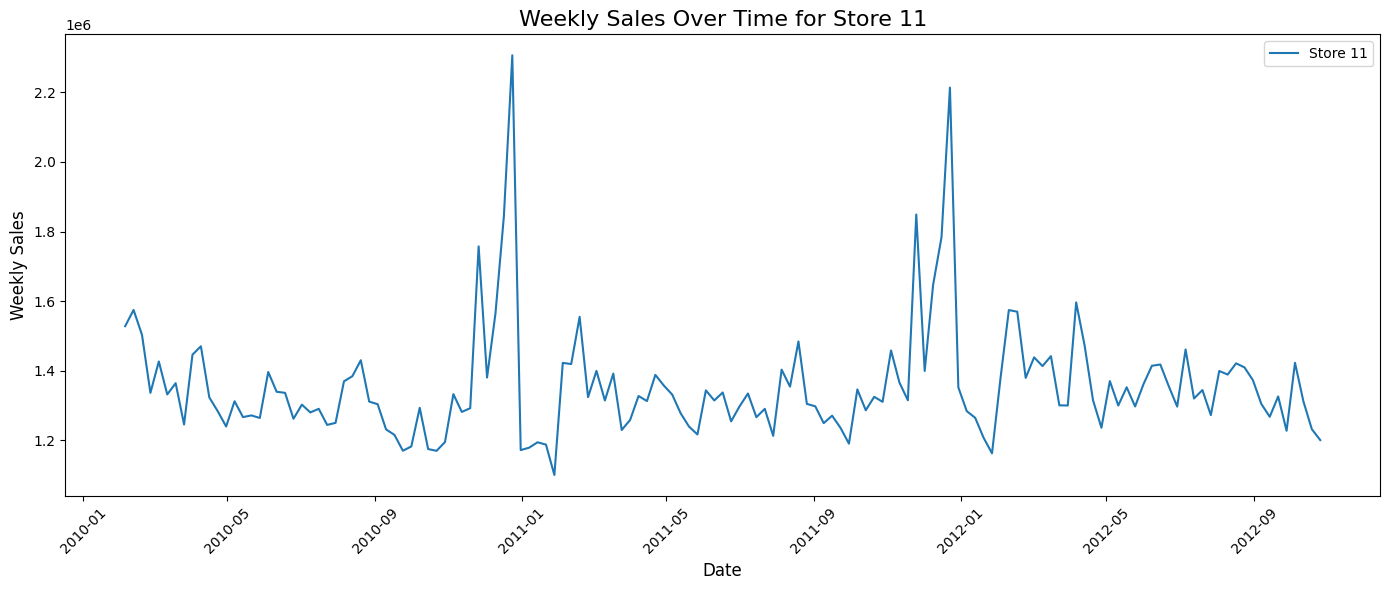

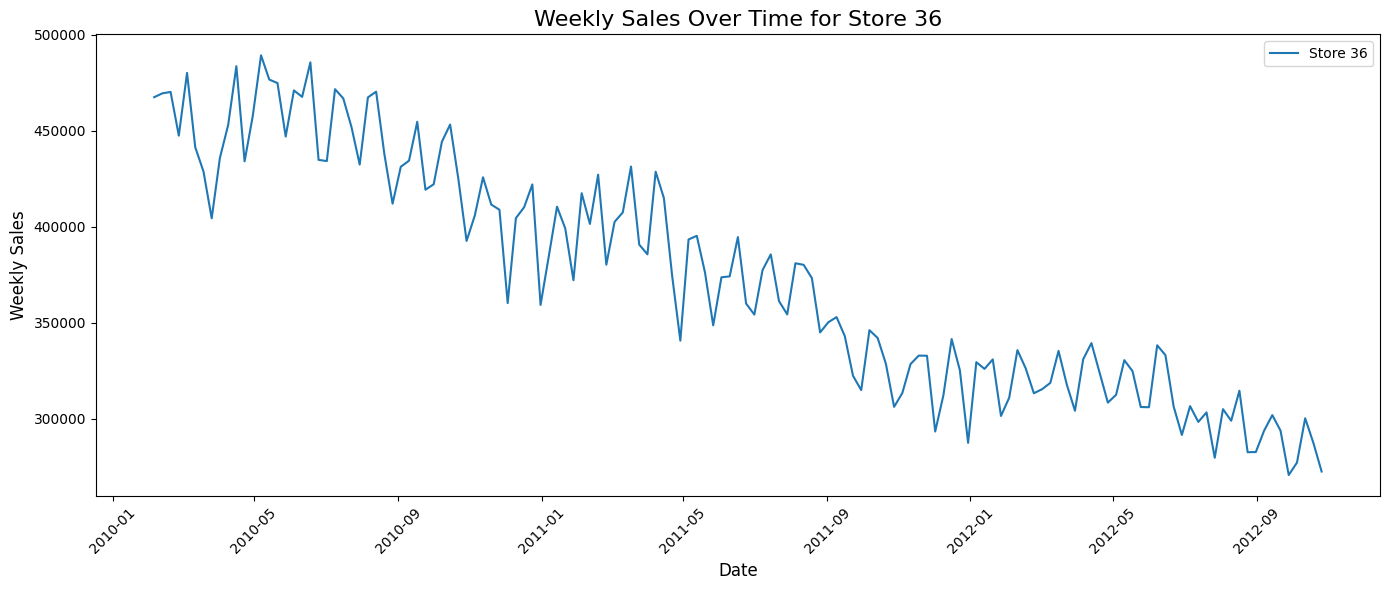

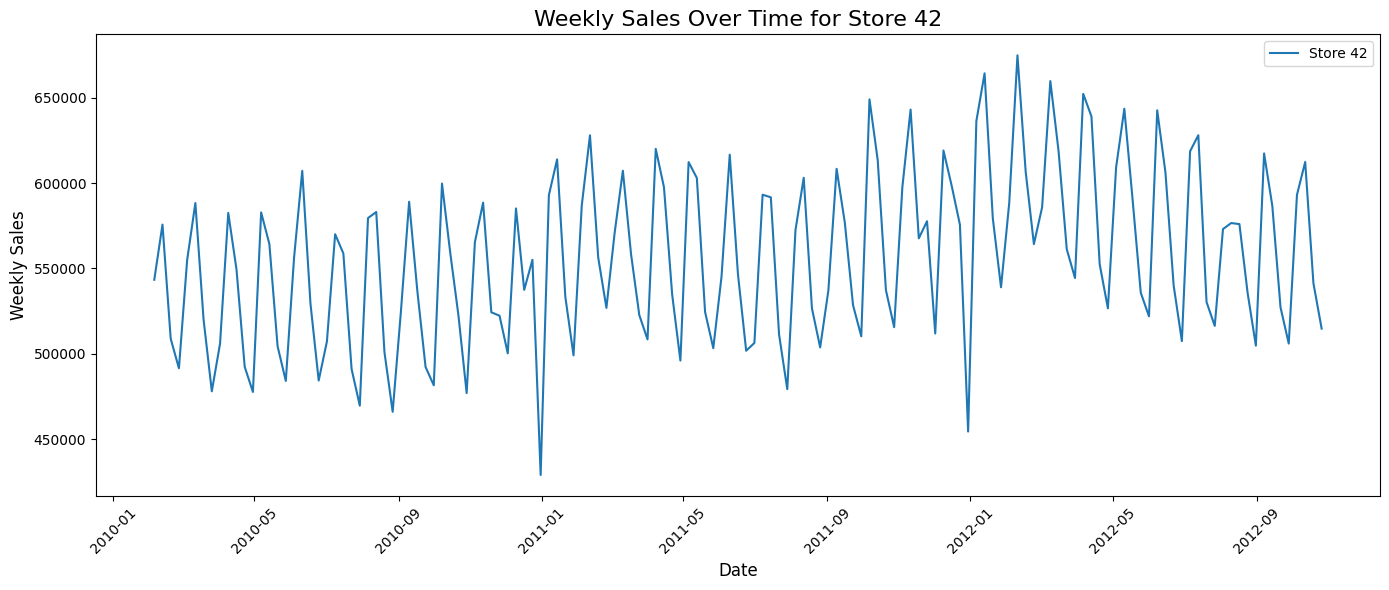

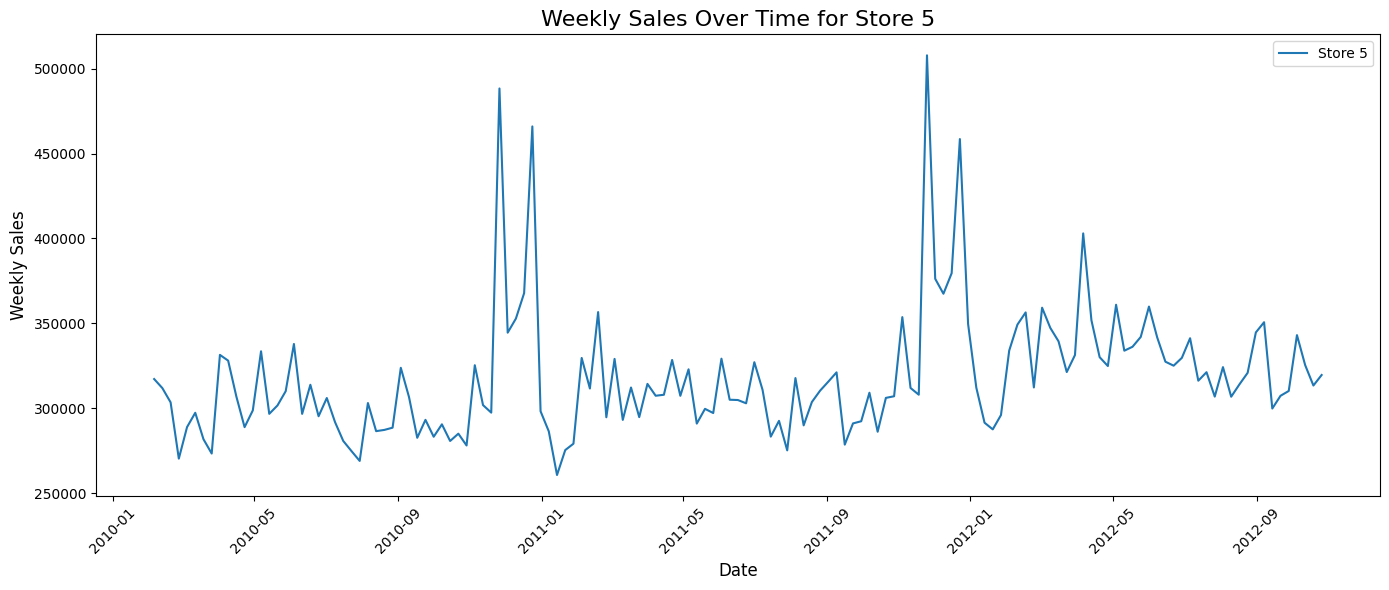

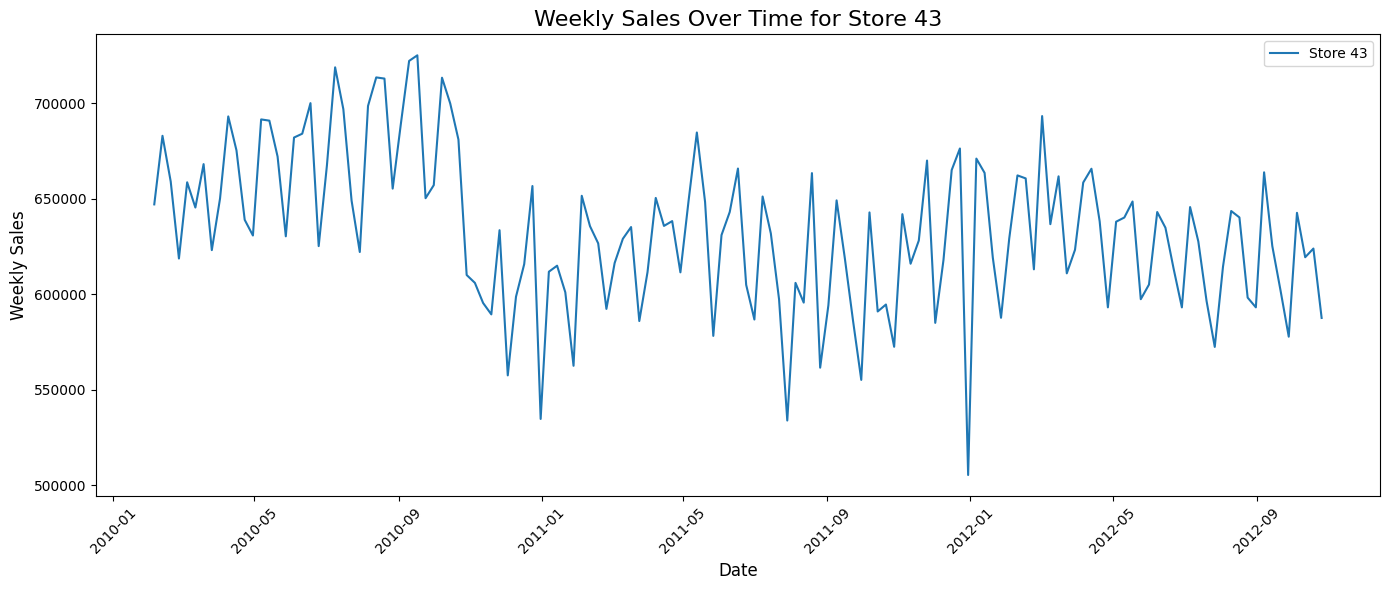

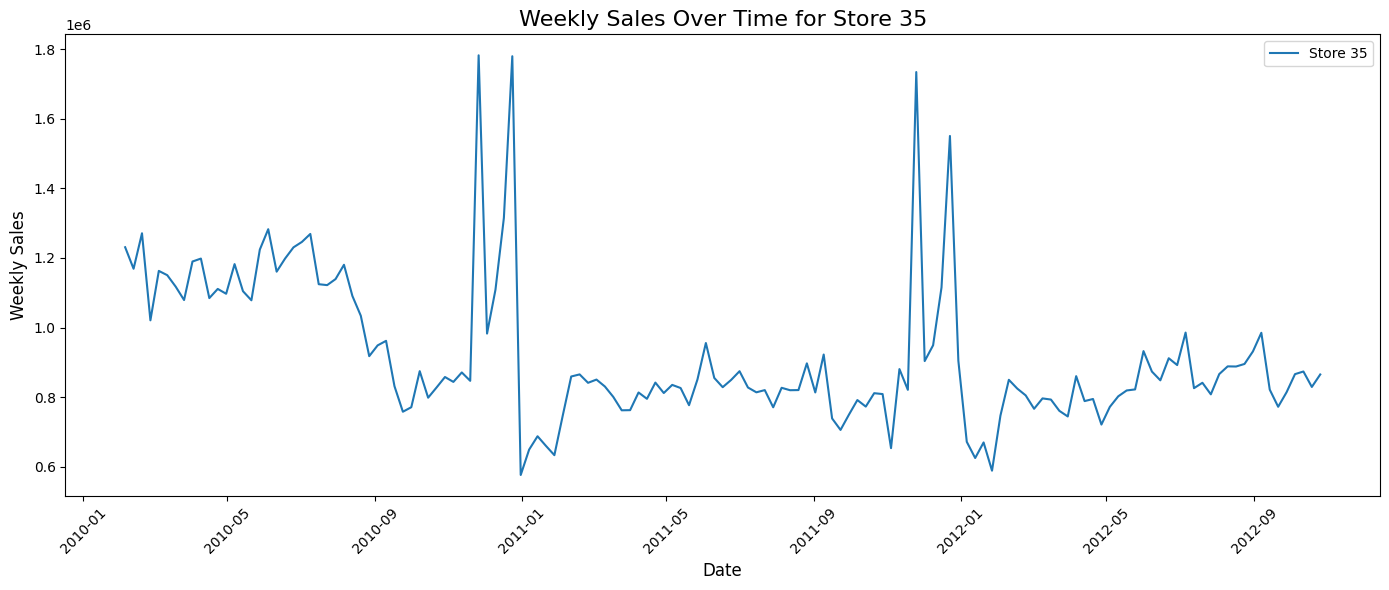

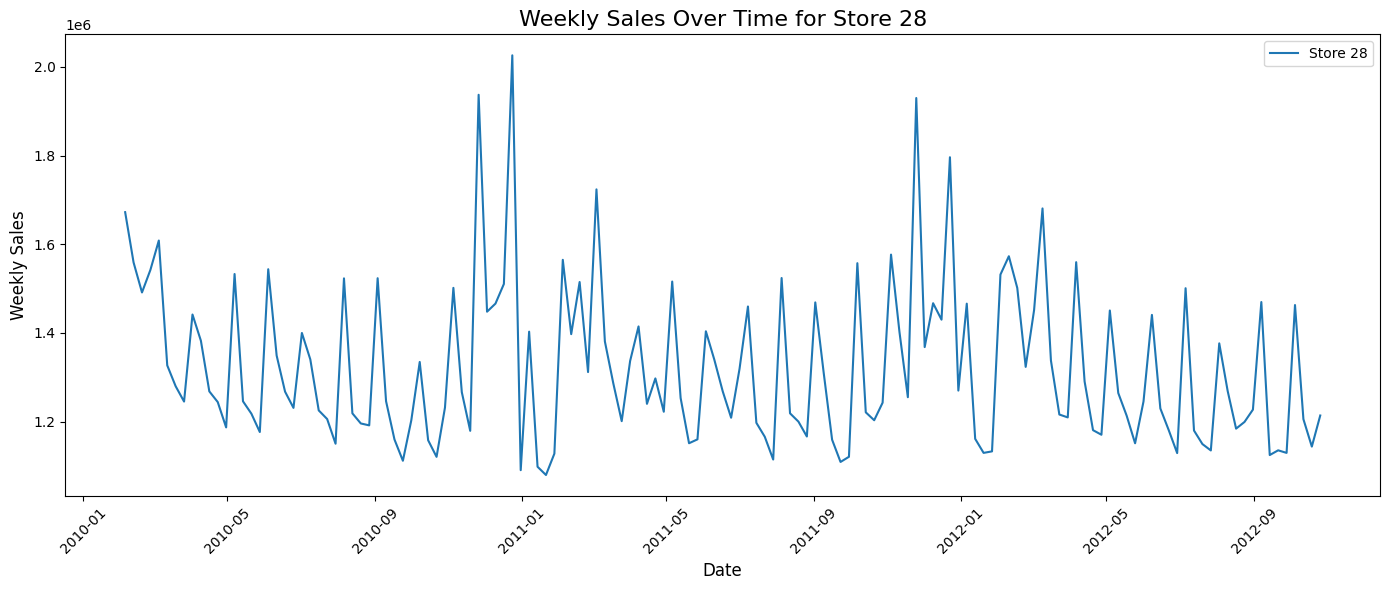

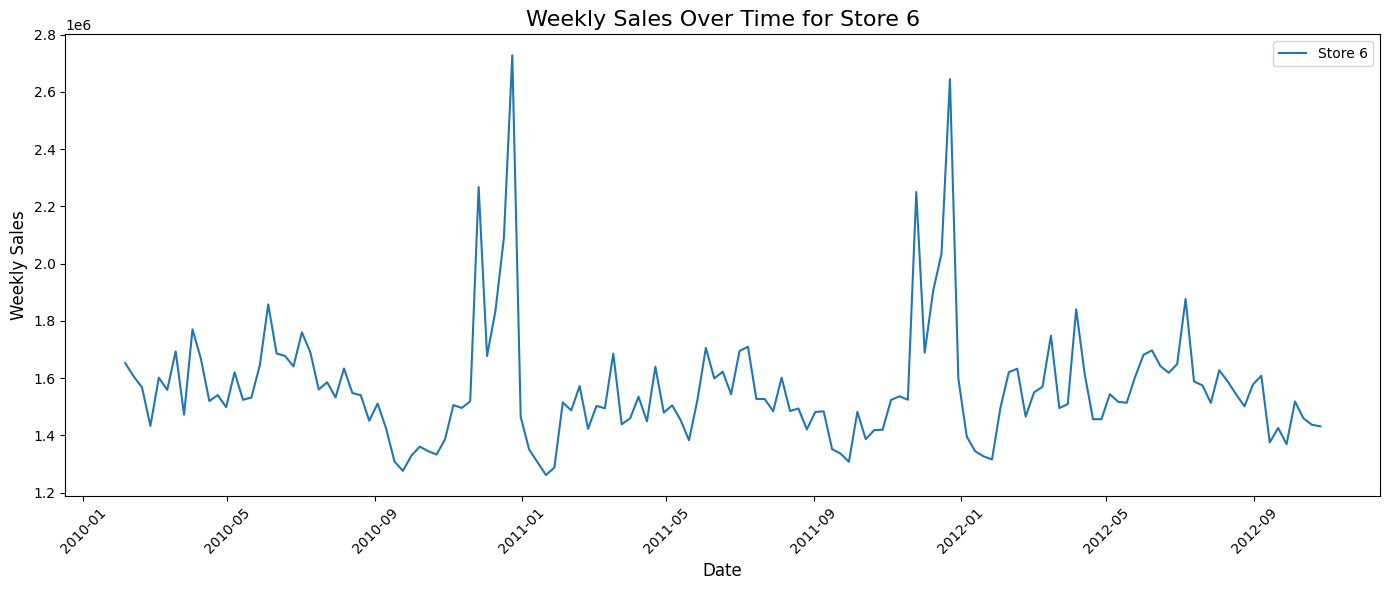

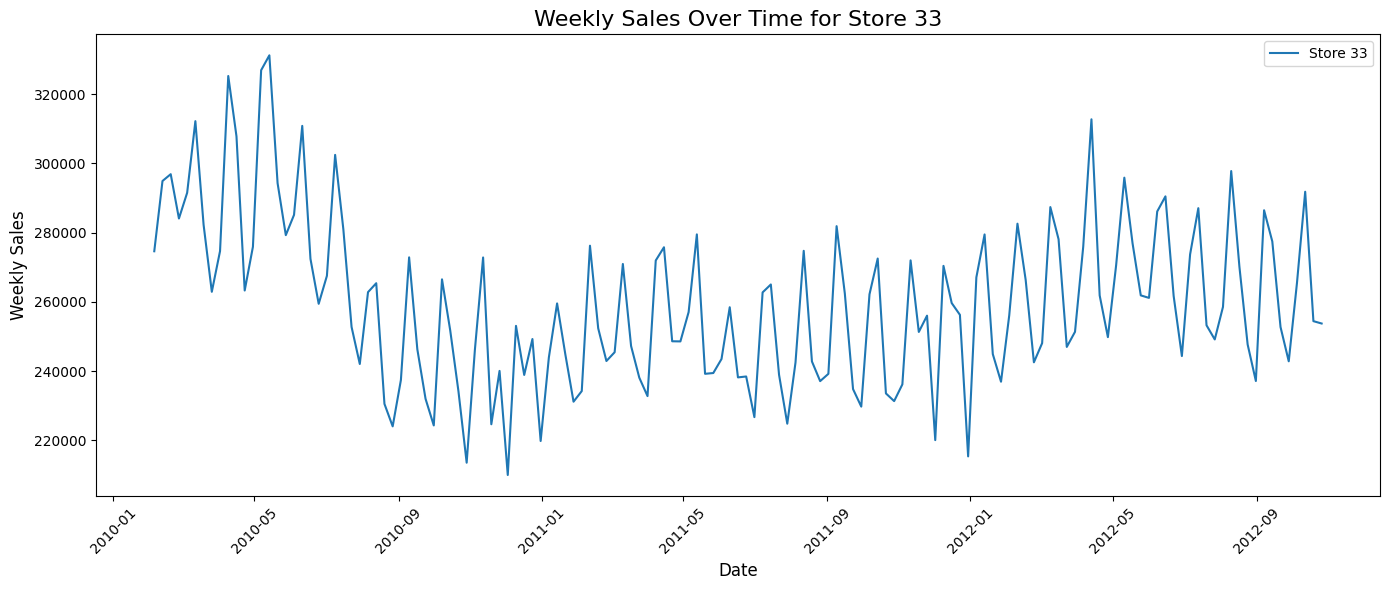

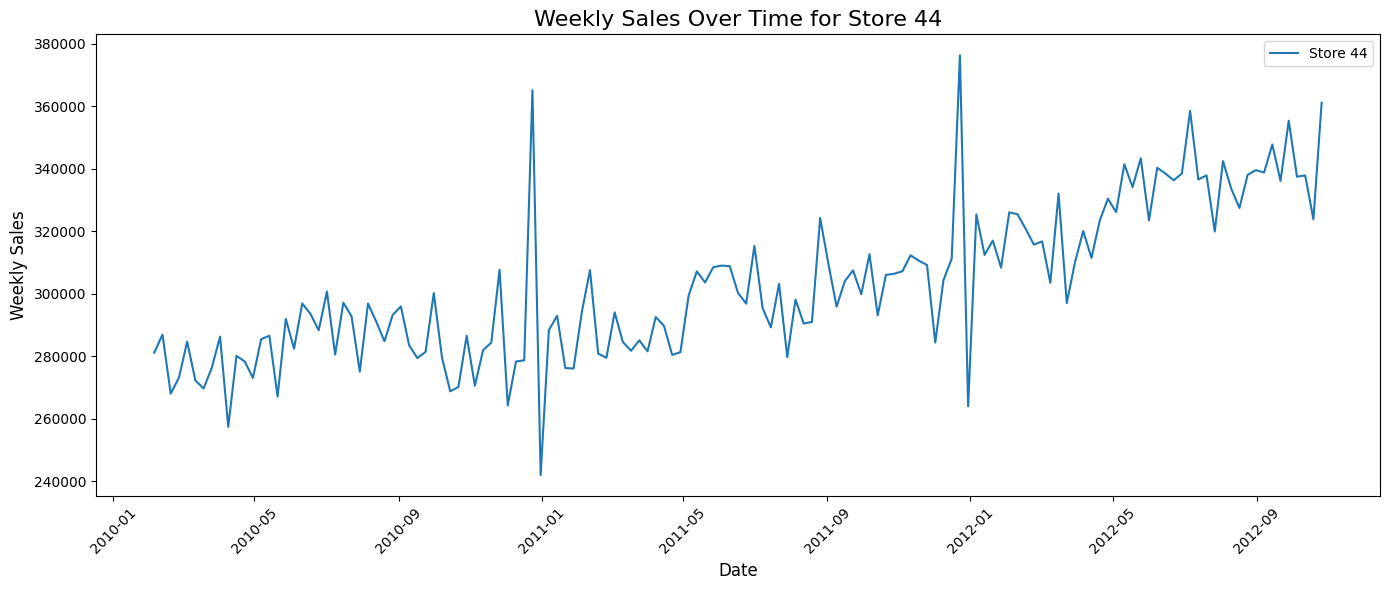

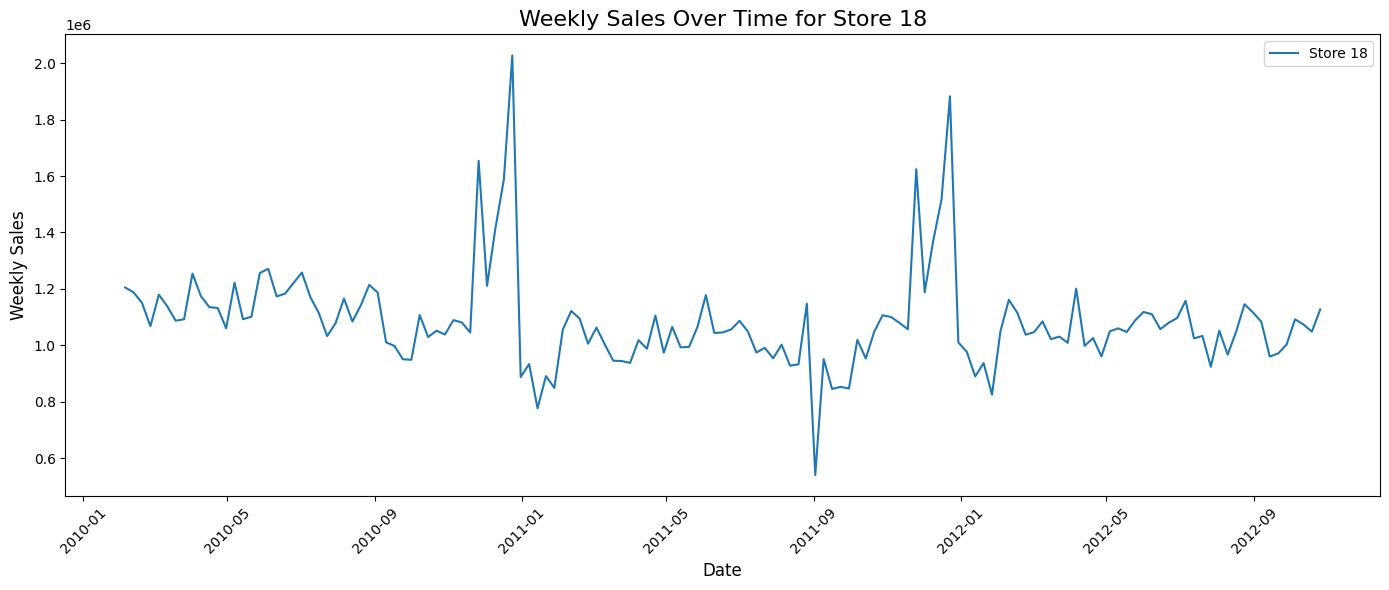

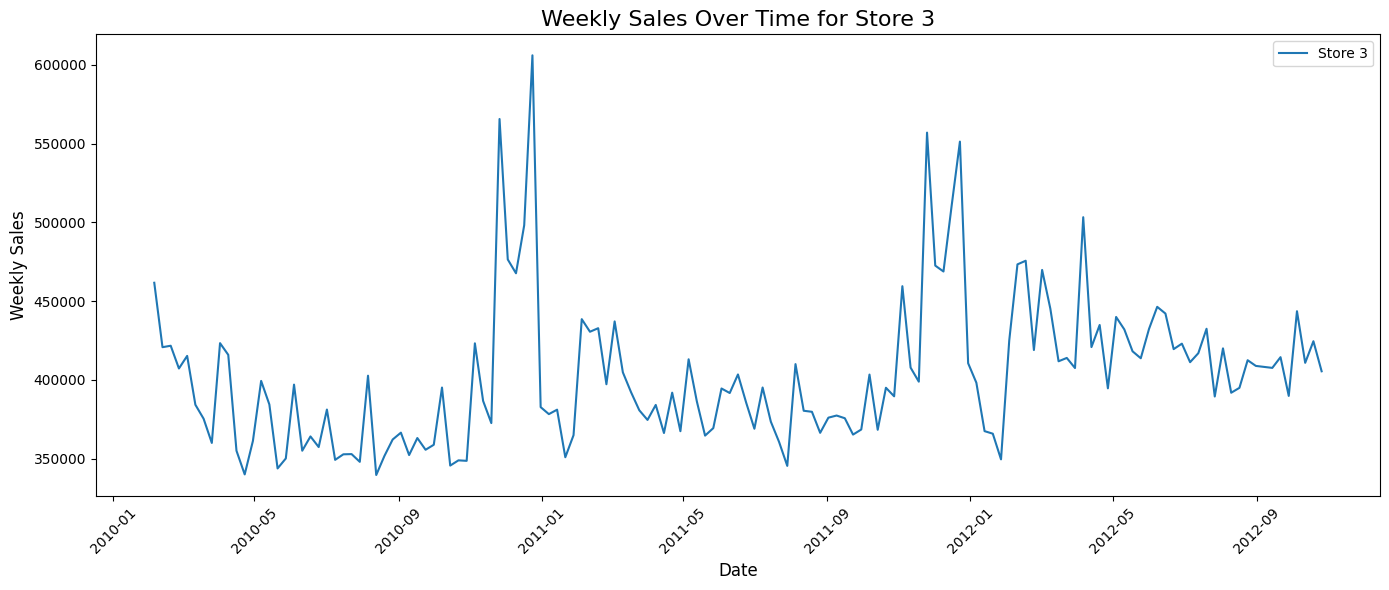

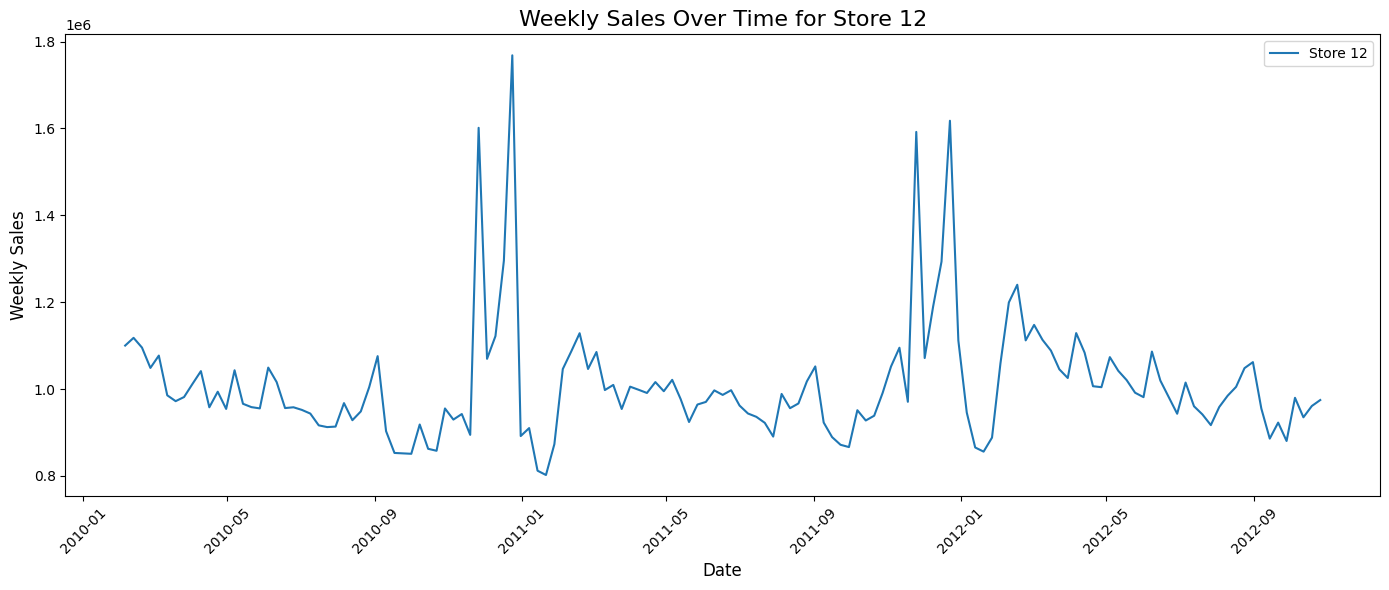

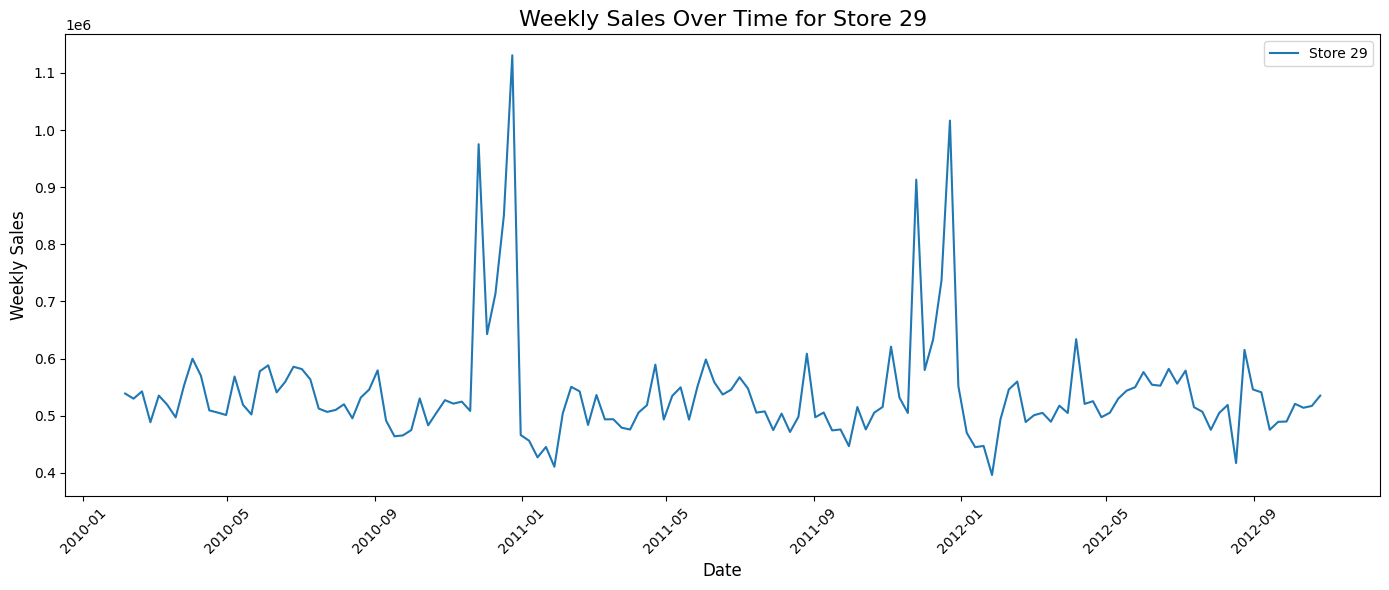

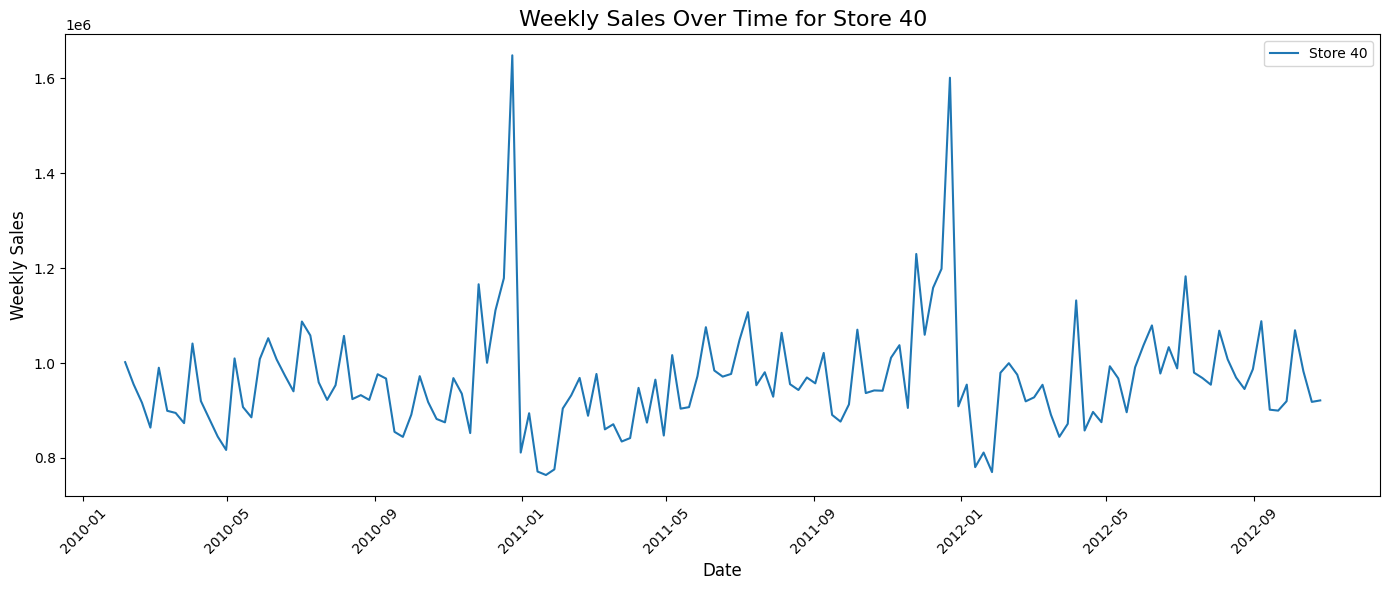

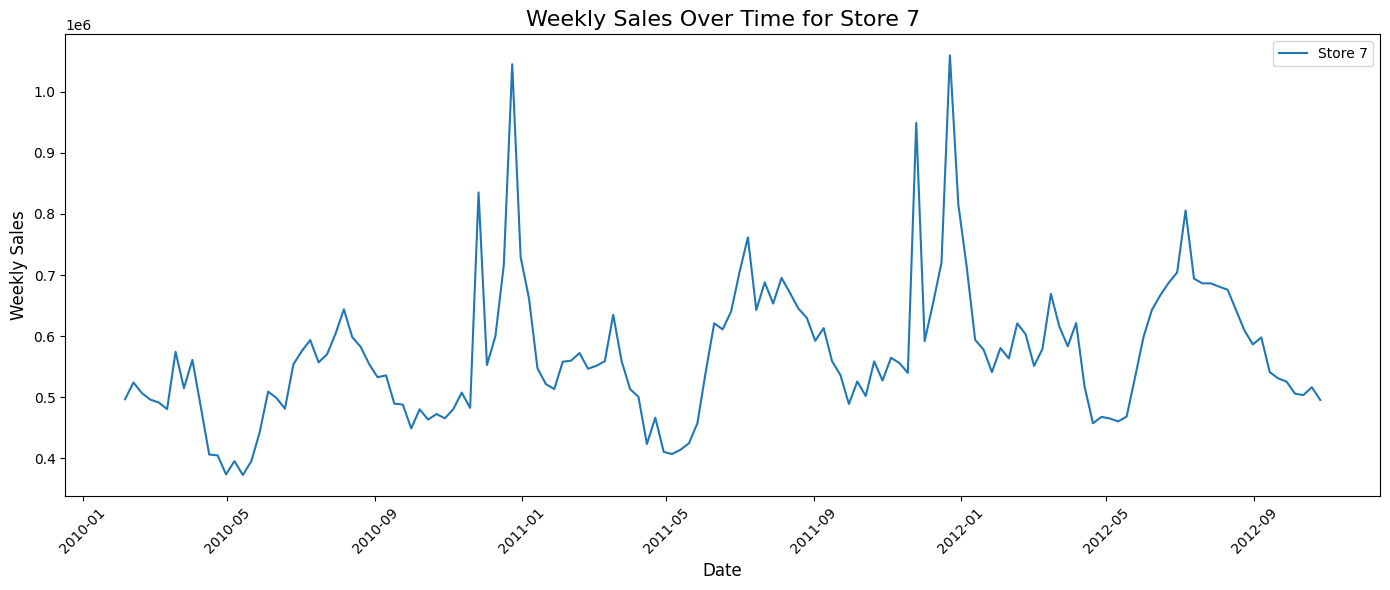

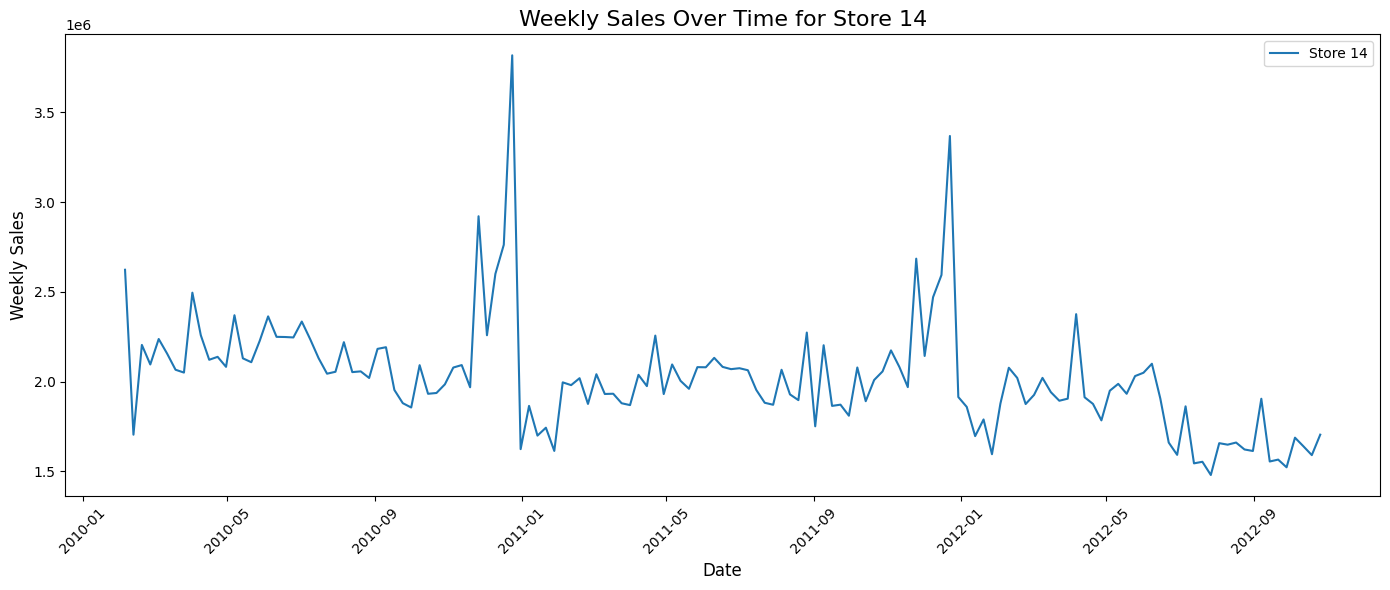

In [6]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Assuming df is your DataFrame
# Convert 'Date' column to datetime format if it's not already
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

# Sort the DataFrame by 'Date' for proper plotting
df = df.sort_values('Date')

# Get a list of unique stores
store_list = df['Store'].unique()

# Plotting the Weekly Sales over Time for each store
for store in store_list:
    store_data = df[df['Store'] == store]

    plt.figure(figsize=(14, 6))
    plt.plot(store_data['Date'], store_data['Weekly_Sales'], label=f'Store {store}')

    # Customize the x-axis ticks to improve readability
    plt.xticks(rotation=45)

    # Set labels and title
    plt.title(f'Weekly Sales Over Time for Store {store}', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Weekly Sales', fontsize=12)
    plt.legend()

    # Show the plot
    plt.tight_layout()
    plt.show()


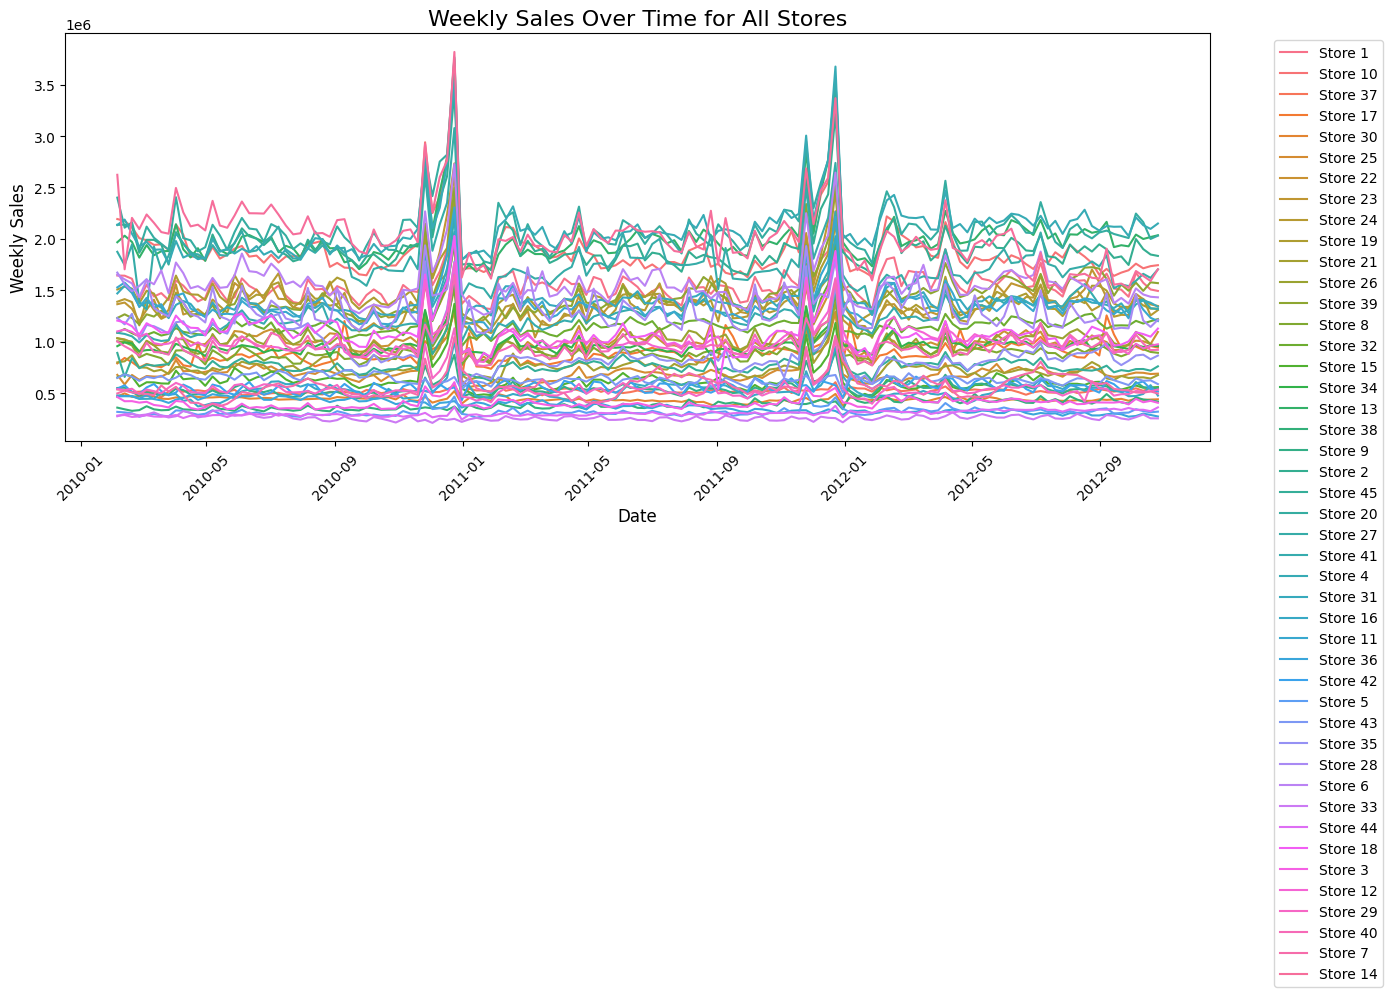

In [7]:
# Create a color palette
palette = sns.color_palette('husl', n_colors=len(store_list))

plt.figure(figsize=(14, 8))

# Plotting the Weekly Sales over Time for all stores
for i, store in enumerate(store_list):
    store_data = df[df['Store'] == store]
    plt.plot(store_data['Date'], store_data['Weekly_Sales'], label=f'Store {store}', color=palette[i])

# Customize the x-axis ticks
plt.xticks(rotation=45)

# Set labels and title
plt.title('Weekly Sales Over Time for All Stores', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Weekly Sales', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Place legend outside the plot

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


In [8]:
# Normalize the target (Weekly_Sales) and other features globally
scaler_sales = MinMaxScaler()
df['Weekly_Sales'] = scaler_sales.fit_transform(df[['Weekly_Sales']])

scaler_features = MinMaxScaler()
df[['Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']] = scaler_features.fit_transform(
    df[['Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']])



In [9]:
# Prepare the data for LSTM (inputs and outputs) with store information
def create_sequences(features, target, time_steps=1):
    X, y = [], []
    for i in range(len(features) - time_steps):
        X.append(features[i:(i + time_steps), :])
        y.append(target[i + time_steps])
    return np.array(X), np.array(y)

# Set time steps (sequence length) for LSTM
time_steps = 4

# Prepare to store results
all_actual_sales = []
all_predicted_sales = []



In [10]:
# Loop through each store and train the model separately
for store_id, store_data in df.groupby('Store'):
    print(f"Training for Store {store_id}...")

    # Get the features and target for the store
    features = store_data[['Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']].values
    target = store_data['Weekly_Sales'].values

    # Prepare sequences for LSTM
    X, y = create_sequences(features, target, time_steps)

    # Split the data into training and testing sets for this store
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))  # Dropout layer to prevent overfitting
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test), verbose=1)

    # Make predictions for the store
    predicted_sales = model.predict(X_test)

    # Store the actual and predicted sales
    all_actual_sales.extend(scaler_sales.inverse_transform(y_test.reshape(-1, 1)))
    all_predicted_sales.extend(scaler_sales.inverse_transform(predicted_sales))



Training for Store 1...
Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - loss: 0.1134 - val_loss: 0.0391
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0374 - val_loss: 7.9876e-04
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0062 - val_loss: 0.0163
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0166 - val_loss: 0.0128
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0101 - val_loss: 0.0019
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0044 - val_loss: 0.0011
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0057 - val_loss: 0.0027
Epoch 8/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0060 - val_loss: 0.0019
Epoch 9/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0058 - val_loss: 6.3058e-04
Epoch 10/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0050 - val_loss: 0.0012
Epoch 11/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0042 - val_loss: 0.0021
Epoch 12/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0052 - val_loss: 0.0014
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - loss: 0.2741 - val_loss: 0.1528
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1511 - val_loss: 0.0607
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0715 - val_loss: 0.0079
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0167 - val_loss: 0.0084
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0163 - val_loss: 0.0338
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0239 - val_loss: 0.0205
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0165 - val_loss: 0.0040
Epoch 8/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0101 - val_loss: 6.4888e-04
Epoch 9/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0086 - val_loss: 0.0012
Epoch 10/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0152 - val_loss: 7.6386e-04
Epoch 11/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0095 - val_loss: 8.5067e-04
Epoch 12/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0107 - val_loss: 0.0024

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 156ms/step - loss: 0.0013 - val_loss: 2.0742e-04
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 6.5476e-04 - val_loss: 5.4370e-04
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 6.6897e-04 - val_loss: 4.1859e-05
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 5.5565e-04 - val_loss: 6.8671e-05
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 5.9706e-04 - val_loss: 2.3239e-04
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 5.2080e-04 - val_loss: 7.3171e-05
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 3.8921e-04 - val_loss: 3.3207e-05
Epoch 8/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 3.3859e-04 - val_loss: 1.1728e-04
Epoch 9/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 3.8542e-04 - val_loss: 1.2225e-04
Epoch 10/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 3.5433e-04 - val_loss: 5.8862e-05
Epoch 11/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 2.7039e-04 - val_loss: 2.7085e-05
Epoch 12/30

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - loss: 0.2906 - val_loss: 0.2298
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2020 - val_loss: 0.1378
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1346 - val_loss: 0.0605
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0635 - val_loss: 0.0087
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0200 - val_loss: 0.0079
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0204 - val_loss: 0.0284
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0286 - val_loss: 0.0136
Epoch 8/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0164 - val_loss: 0.0017
Epoch 9/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0144 - val_loss: 0.0016
Epoch 10/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0123 - val_loss: 0.0026
Epoch 11/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0146 - val_loss: 0.0017
Epoch 12/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0129 - val_loss: 9.9988e-04
Epoch 1

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 195ms/step - loss: 0.0013 - val_loss: 7.7707e-04
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0012 - val_loss: 6.0411e-05
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.5928e-04 - val_loss: 5.4390e-05
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.7877e-04 - val_loss: 3.7161e-05
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.9965e-04 - val_loss: 2.6060e-05
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.7105e-04 - val_loss: 4.8091e-05
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 3.2017e-04 - val_loss: 1.9828e-05
Epoch 8/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.0044e-04 - val_loss: 1.9019e-05
Epoch 9/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 3.5220e-04 - val_loss: 1.8815e-05
Epoch 10/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 2.3668e-04 - val_loss: 2.4817e-05
Epoch 11/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.2062e-04 - val_loss: 1.9405e-05
Epoch 12/30
4/4

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
Training for Store 6...
Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - loss: 0.1705 - val_loss: 0.0833
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0765 - val_loss: 0.0213
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0257 - val_loss: 0.0013
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0069 - val_loss: 0.0186
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0175 - val_loss: 0.0165
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0125 - val_loss: 0.0045
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0059 - val_loss: 0.0010
Epoch 8/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0069 - val_loss: 0.0015
Epoch 9/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0077 - val_loss: 0.0015
Epoch 10/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0085 - val_loss: 0.0010
Epoch 11/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0073 - val_loss: 0.0018
Epoch 12/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0057 - val_loss: 0.0029
Epoch 13/30

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step
Training for Store 7...
Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - loss: 0.0082 - val_loss: 8.1892e-04
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0025 - val_loss: 0.0019
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0024 - val_loss: 7.3289e-04
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0021 - val_loss: 0.0012
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0015 - val_loss: 7.4837e-04
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0014 - val_loss: 8.4738e-04
Epoch 8/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0013 - val_loss: 8.8104e-04
Epoch 9/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0015 - val_loss: 7.5801e-04
Epoch 10/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0011 - val_loss: 8.2733e-04
Epoch 11/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0011 - val_loss: 8.0081e-04
Epoch 12/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.001

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 211ms/step - loss: 0.0194 - val_loss: 1.6712e-04
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0030 - val_loss: 0.0056
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0050 - val_loss: 0.0023
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0026 - val_loss: 8.6316e-05
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0026 - val_loss: 3.9508e-04
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0025 - val_loss: 1.4614e-04
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0024 - val_loss: 2.3014e-04
Epoch 8/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0016 - val_loss: 5.1703e-04
Epoch 9/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0014 - val_loss: 3.5152e-04
Epoch 10/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0019 - val_loss: 1.3006e-04
Epoch 11/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0016 - val_loss: 9.9600e-05
Epoch 12/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - loss: 0.0057 - val_loss: 0.0022
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0026 - val_loss: 0.0017
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0015 - val_loss: 1.2105e-04
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0011 - val_loss: 5.7143e-04
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0014 - val_loss: 5.2594e-05
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 9.2743e-04 - val_loss: 3.0640e-04
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 8.5394e-04 - val_loss: 3.0586e-04
Epoch 8/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 7.9504e-04 - val_loss: 4.6545e-05
Epoch 9/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 8.0937e-04 - val_loss: 8.0382e-05
Epoch 10/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.0157e-04 - val_loss: 4.6821e-05
Epoch 11/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 5.5466e-04 - val_loss: 1.0814e-04
Epoch 12/30
4/4 ━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - loss: 0.2413 - val_loss: 0.1160
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1304 - val_loss: 0.0432
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0619 - val_loss: 0.0031
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0193 - val_loss: 0.0155
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0239 - val_loss: 0.0344
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0288 - val_loss: 0.0161
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0140 - val_loss: 0.0034
Epoch 8/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0171 - val_loss: 9.6992e-04
Epoch 9/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0162 - val_loss: 9.0085e-04
Epoch 10/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0155 - val_loss: 0.0011
Epoch 11/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0106 - val_loss: 0.0030
Epoch 12/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0121 - val_loss: 0.0056
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - loss: 0.0448 - val_loss: 0.0047
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0100 - val_loss: 0.0071
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0092 - val_loss: 0.0094
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0080 - val_loss: 0.0011
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0035 - val_loss: 0.0011
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0066 - val_loss: 0.0016
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0057 - val_loss: 5.5237e-04
Epoch 8/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0049 - val_loss: 5.0944e-04
Epoch 9/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0048 - val_loss: 0.0011
Epoch 10/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0044 - val_loss: 0.0011
Epoch 11/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0042 - val_loss: 4.4665e-04
Epoch 12/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0045 - val_loss: 3.7038

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - loss: 0.0339 - val_loss: 0.0028
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0055 - val_loss: 0.0055
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0081 - val_loss: 0.0083
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0084 - val_loss: 0.0014
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0040 - val_loss: 5.8657e-04
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0040 - val_loss: 0.0013
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0046 - val_loss: 7.8637e-04
Epoch 8/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0029 - val_loss: 3.1636e-04
Epoch 9/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0030 - val_loss: 6.0950e-04
Epoch 10/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0026 - val_loss: 7.3184e-04
Epoch 11/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0030 - val_loss: 4.4706e-04
Epoch 12/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0029 - val_

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 256ms/step - loss: 0.2143 - val_loss: 0.1271
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1458 - val_loss: 0.0502
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0714 - val_loss: 0.0042
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0230 - val_loss: 0.0218
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0242 - val_loss: 0.0609
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0295 - val_loss: 0.0374
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0202 - val_loss: 0.0090
Epoch 8/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0151 - val_loss: 0.0016
Epoch 9/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0168 - val_loss: 0.0012
Epoch 10/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0155 - val_loss: 0.0013
Epoch 11/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0151 - val_loss: 0.0029
Epoch 12/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0152 - val_loss: 0.0059
Epoch 13/30

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - loss: 0.2507 - val_loss: 0.0835
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1526 - val_loss: 0.0227
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0787 - val_loss: 0.0037
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0197 - val_loss: 0.0584
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0229 - val_loss: 0.1175
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0328 - val_loss: 0.0722
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0191 - val_loss: 0.0310
Epoch 8/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0111 - val_loss: 0.0138
Epoch 9/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0164 - val_loss: 0.0117
Epoch 10/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0155 - val_loss: 0.0166
Epoch 11/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0109 - val_loss: 0.0264
Epoch 12/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0136 - val_loss: 0.0349
Epoch 13/30

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - loss: 0.0080 - val_loss: 0.0028
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0028 - val_loss: 0.0053
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0031 - val_loss: 0.0013
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0021 - val_loss: 2.7246e-04
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0018 - val_loss: 2.5696e-04
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0020 - val_loss: 8.0819e-04
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 8/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0015 - val_loss: 6.9608e-04
Epoch 9/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0019 - val_loss: 3.3474e-04
Epoch 10/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0015 - val_loss: 2.9676e-04
Epoch 11/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0023 - val_loss: 4.0294e-04
Epoch 12/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0019 - 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 232ms/step - loss: 0.0044 - val_loss: 0.0014
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0013 - val_loss: 2.3037e-04
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 9.6518e-04 - val_loss: 4.6733e-04
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0012 - val_loss: 2.0747e-04
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 8.5044e-04 - val_loss: 6.2805e-04
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0011 - val_loss: 4.2573e-04
Epoch 8/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 8.2899e-04 - val_loss: 2.1903e-04
Epoch 9/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 7.7525e-04 - val_loss: 2.0978e-04
Epoch 10/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 9.8147e-04 - val_loss: 2.0355e-04
Epoch 11/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 5.7297e-04 - val_loss: 2.5267e-04
Epoch 12/30
4/4 ━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - loss: 0.0280 - val_loss: 0.0057
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0070 - val_loss: 0.0020
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0033 - val_loss: 0.0065
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0040 - val_loss: 0.0028
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0023 - val_loss: 6.5773e-04
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0024 - val_loss: 9.4051e-04
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0020 - val_loss: 0.0010
Epoch 8/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0019 - val_loss: 6.9066e-04
Epoch 9/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0019 - val_loss: 6.1583e-04
Epoch 10/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0014 - val_loss: 6.3488e-04
Epoch 11/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0012 - val_loss: 6.0976e-04
Epoch 12/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0017 - val_

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - loss: 0.0554 - val_loss: 0.0143
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0177 - val_loss: 4.4589e-04
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0059 - val_loss: 0.0109
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0090 - val_loss: 0.0119
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0077 - val_loss: 0.0051
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0052 - val_loss: 0.0012
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0042 - val_loss: 4.4235e-04
Epoch 8/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0046 - val_loss: 4.4216e-04
Epoch 9/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0052 - val_loss: 4.8386e-04
Epoch 10/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0041 - val_loss: 8.3895e-04
Epoch 11/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0042 - val_loss: 0.0013
Epoch 12/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0049 - val_loss

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 192ms/step - loss: 0.1185 - val_loss: 0.0371
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0507 - val_loss: 0.0025
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0155 - val_loss: 0.0137
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0096 - val_loss: 0.0429
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0168 - val_loss: 0.0270
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0102 - val_loss: 0.0084
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0068 - val_loss: 0.0020
Epoch 8/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0070 - val_loss: 0.0011
Epoch 9/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0066 - val_loss: 0.0014
Epoch 10/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0072 - val_loss: 0.0028
Epoch 11/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0049 - val_loss: 0.0051
Epoch 12/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0055 - val_loss: 0.0063
Epoch 13/30

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - loss: 0.2571 - val_loss: 0.1250
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1338 - val_loss: 0.0319
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0525 - val_loss: 0.0019
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0149 - val_loss: 0.0418
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0270 - val_loss: 0.0437
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0254 - val_loss: 0.0145
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0123 - val_loss: 0.0026
Epoch 8/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0122 - val_loss: 9.7140e-04
Epoch 9/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0140 - val_loss: 9.7618e-04
Epoch 10/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0120 - val_loss: 0.0017
Epoch 11/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0097 - val_loss: 0.0036
Epoch 12/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0110 - val_loss: 0.0055
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - loss: 0.0324 - val_loss: 3.0264e-04
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0047 - val_loss: 0.0118
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0060 - val_loss: 0.0120
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0045 - val_loss: 0.0035
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0026 - val_loss: 3.9655e-04
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0026 - val_loss: 1.5330e-04
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0026 - val_loss: 3.4838e-04
Epoch 8/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0028 - val_loss: 0.0016
Epoch 9/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0019 - val_loss: 0.0027
Epoch 10/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 11/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0026 - val_loss: 0.0012
Epoch 12/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0021 - val_loss: 6.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 153ms/step - loss: 0.0397 - val_loss: 0.0063
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0101 - val_loss: 0.0028
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0044 - val_loss: 0.0139
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0075 - val_loss: 0.0090
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0051 - val_loss: 0.0024
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0038 - val_loss: 4.9947e-04
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0048 - val_loss: 4.4903e-04
Epoch 8/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0036 - val_loss: 4.4444e-04
Epoch 9/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0036 - val_loss: 8.7538e-04
Epoch 10/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0040 - val_loss: 0.0020
Epoch 11/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0034 - val_loss: 0.0020
Epoch 12/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0038 - val_loss: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - loss: 0.0933 - val_loss: 0.0426
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0510 - val_loss: 0.0055
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0149 - val_loss: 0.0068
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0126 - val_loss: 0.0238
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0150 - val_loss: 0.0160
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0126 - val_loss: 0.0046
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0070 - val_loss: 0.0010
Epoch 8/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0083 - val_loss: 8.7819e-04
Epoch 9/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0073 - val_loss: 9.6333e-04
Epoch 10/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0086 - val_loss: 0.0018
Epoch 11/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0060 - val_loss: 0.0031
Epoch 12/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0080 - val_loss: 0.0035
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 166ms/step - loss: 0.0900 - val_loss: 0.0293
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0343 - val_loss: 0.0012
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0082 - val_loss: 0.0168
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0121 - val_loss: 0.0290
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0135 - val_loss: 0.0118
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0068 - val_loss: 0.0021
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0072 - val_loss: 7.4919e-04
Epoch 8/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0072 - val_loss: 7.4145e-04
Epoch 9/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0062 - val_loss: 0.0011
Epoch 10/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0050 - val_loss: 0.0028
Epoch 11/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0045 - val_loss: 0.0046
Epoch 12/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0039 - val_loss: 0.0042
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - loss: 0.0355 - val_loss: 0.0051
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0046 - val_loss: 0.0031
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0045 - val_loss: 0.0067
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0057 - val_loss: 0.0020
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0023 - val_loss: 1.3297e-04
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0020 - val_loss: 7.2043e-04
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0029 - val_loss: 8.2109e-04
Epoch 8/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0027 - val_loss: 3.1279e-04
Epoch 9/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0019 - val_loss: 1.1435e-04
Epoch 10/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0017 - val_loss: 3.9278e-04
Epoch 11/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0018 - val_loss: 5.0779e-04
Epoch 12/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0019 - 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - loss: 0.0435 - val_loss: 0.0171
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0177 - val_loss: 8.4279e-04
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0042 - val_loss: 0.0065
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0050 - val_loss: 0.0117
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0066 - val_loss: 0.0047
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0033 - val_loss: 6.2763e-04
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0022 - val_loss: 2.8394e-04
Epoch 8/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0030 - val_loss: 3.2197e-04
Epoch 9/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0029 - val_loss: 2.9008e-04
Epoch 10/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0023 - val_loss: 5.5295e-04
Epoch 11/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 12/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0018 - val_

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 207ms/step - loss: 0.1731 - val_loss: 0.0773
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0965 - val_loss: 0.0159
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0354 - val_loss: 0.0051
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0092 - val_loss: 0.0487
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0211 - val_loss: 0.0526
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0206 - val_loss: 0.0210
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0096 - val_loss: 0.0057
Epoch 8/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0093 - val_loss: 0.0023
Epoch 9/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0121 - val_loss: 0.0020
Epoch 10/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0114 - val_loss: 0.0032
Epoch 11/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0100 - val_loss: 0.0070
Epoch 12/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0096 - val_loss: 0.0120
Epoch 13/30

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - loss: 0.0808 - val_loss: 0.0165
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0239 - val_loss: 0.0016
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0049 - val_loss: 0.0175
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0150 - val_loss: 0.0127
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0104 - val_loss: 0.0026
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0046 - val_loss: 0.0011
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0059 - val_loss: 0.0015
Epoch 8/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0061 - val_loss: 0.0012
Epoch 9/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0060 - val_loss: 0.0013
Epoch 10/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0056 - val_loss: 0.0024
Epoch 11/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0043 - val_loss: 0.0028
Epoch 12/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0055 - val_loss: 0.0023
Epoch 13/30

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 155ms/step - loss: 0.0125 - val_loss: 3.2882e-04
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0023 - val_loss: 0.0040
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0033 - val_loss: 0.0013
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0015 - val_loss: 2.7708e-04
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0015 - val_loss: 5.5483e-04
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0014 - val_loss: 2.6581e-04
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0016 - val_loss: 2.7282e-04
Epoch 8/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0016 - val_loss: 3.7906e-04
Epoch 9/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0013 - val_loss: 2.7736e-04
Epoch 10/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 8.3756e-04 - val_loss: 1.9440e-04
Epoch 11/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0012 - val_loss: 1.8995e-04
Epoch 12/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 180ms/step - loss: 0.0026 - val_loss: 0.0013
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0018 - val_loss: 3.9145e-05
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 3.9374e-04 - val_loss: 6.0083e-04
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 7.7873e-04 - val_loss: 1.7834e-04
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 3.9863e-04 - val_loss: 5.3989e-05
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 2.9035e-04 - val_loss: 5.8576e-05
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 3.2639e-04 - val_loss: 6.6148e-05
Epoch 8/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 2.6480e-04 - val_loss: 1.3252e-04
Epoch 9/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.4291e-04 - val_loss: 5.5885e-05
Epoch 10/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 2.1510e-04 - val_loss: 2.7661e-05
Epoch 11/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 3.0113e-04 - val_loss: 6.3004e-05
Epoch 12/30
4/4 ━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - loss: 0.0755 - val_loss: 0.0183
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0199 - val_loss: 0.0011
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0061 - val_loss: 0.0178
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0099 - val_loss: 0.0118
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0054 - val_loss: 0.0024
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0031 - val_loss: 3.0181e-04
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0035 - val_loss: 2.5130e-04
Epoch 8/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0054 - val_loss: 3.4250e-04
Epoch 9/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0034 - val_loss: 9.8559e-04
Epoch 10/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0029 - val_loss: 0.0021
Epoch 11/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0029 - val_loss: 0.0031
Epoch 12/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0028 - val_loss: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - loss: 0.0566 - val_loss: 0.0177
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0176 - val_loss: 3.5049e-04
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0034 - val_loss: 0.0065
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0077 - val_loss: 0.0057
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0055 - val_loss: 7.2915e-04
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0026 - val_loss: 4.3718e-04
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0030 - val_loss: 0.0010
Epoch 8/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0034 - val_loss: 5.6973e-04
Epoch 9/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0035 - val_loss: 1.5540e-04
Epoch 10/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0020 - val_loss: 4.5823e-04
Epoch 11/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0027 - val_loss: 5.2616e-04
Epoch 12/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0030 - 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - loss: 6.6307e-04 - val_loss: 4.0488e-04
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 5.2434e-04 - val_loss: 4.3789e-05
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 2.7424e-04 - val_loss: 4.2064e-05
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 2.5411e-04 - val_loss: 7.8690e-05
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.5319e-04 - val_loss: 5.2629e-05
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.6148e-04 - val_loss: 2.4700e-05
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.4073e-04 - val_loss: 3.3221e-05
Epoch 8/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.5962e-04 - val_loss: 3.5670e-05
Epoch 9/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.6781e-04 - val_loss: 2.2347e-05
Epoch 10/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.1812e-04 - val_loss: 1.2591e-04
Epoch 11/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.4893e-04 - val_loss: 3.0365e-05
Epoch 1

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - loss: 0.0223 - val_loss: 0.0012
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0047 - val_loss: 0.0057
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0062 - val_loss: 0.0049
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0041 - val_loss: 4.2787e-04
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0028 - val_loss: 3.4103e-04
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0025 - val_loss: 8.8595e-04
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0041 - val_loss: 3.2292e-04
Epoch 8/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0025 - val_loss: 8.6297e-05
Epoch 9/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0023 - val_loss: 2.4422e-04
Epoch 10/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0018 - val_loss: 1.3578e-04
Epoch 11/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0018 - val_loss: 1.7055e-04
Epoch 12/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.001

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 240ms/step - loss: 0.0425 - val_loss: 0.0037
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0115 - val_loss: 0.0047
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0081 - val_loss: 0.0136
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0095 - val_loss: 0.0079
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0067 - val_loss: 0.0018
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0054 - val_loss: 2.9842e-04
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0051 - val_loss: 2.4052e-04
Epoch 8/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0058 - val_loss: 4.2760e-04
Epoch 9/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0039 - val_loss: 0.0011
Epoch 10/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0036 - val_loss: 0.0016
Epoch 11/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0048 - val_loss: 0.0013
Epoch 12/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0044 - val_loss: 7.1195

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - loss: 0.0012 - val_loss: 0.0029
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0015 - val_loss: 7.4614e-05
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 8.3068e-04 - val_loss: 1.7198e-04
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.8660e-04 - val_loss: 9.0774e-04
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 6.2144e-04 - val_loss: 2.2163e-04
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 5.4424e-04 - val_loss: 9.7009e-05
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 4.0567e-04 - val_loss: 4.2171e-04
Epoch 8/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 3.4710e-04 - val_loss: 3.6058e-04
Epoch 9/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.5516e-04 - val_loss: 1.4518e-04
Epoch 10/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.9210e-04 - val_loss: 3.0757e-04
Epoch 11/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 3.1641e-04 - val_loss: 3.7952e-04
Epoch 12/30
4/4 ━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 151ms/step - loss: 0.0106 - val_loss: 4.2370e-04
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0017 - val_loss: 0.0034
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0026 - val_loss: 2.4517e-04
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 6.6289e-04 - val_loss: 3.8914e-04
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0011 - val_loss: 4.8199e-04
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 8.6606e-04 - val_loss: 1.8418e-05
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 3.8903e-04 - val_loss: 1.9927e-04
Epoch 8/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 4.7644e-04 - val_loss: 2.1536e-04
Epoch 9/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 4.9564e-04 - val_loss: 2.5013e-05
Epoch 10/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 3.3531e-04 - val_loss: 3.9783e-05
Epoch 11/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.3145e-04 - val_loss: 4.5546e-05
Epoch 12/30
4/4 ━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 210ms/step - loss: 7.2098e-04 - val_loss: 2.7806e-04
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 4.4639e-04 - val_loss: 3.0522e-04
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 3.4949e-04 - val_loss: 1.2803e-04
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.0873e-04 - val_loss: 1.4701e-04
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.9778e-04 - val_loss: 2.0693e-04
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.9485e-04 - val_loss: 1.1102e-04
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 2.1553e-04 - val_loss: 1.8007e-04
Epoch 8/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 2.3041e-04 - val_loss: 2.8079e-04
Epoch 9/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.1911e-04 - val_loss: 1.2813e-04
Epoch 10/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.6385e-04 - val_loss: 3.4408e-04
Epoch 11/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.2540e-04 - val_loss: 4.7936e-04
Epoch 1

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - loss: 0.0988 - val_loss: 0.0534
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0356 - val_loss: 0.0078
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0066 - val_loss: 0.0031
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0126 - val_loss: 0.0065
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0122 - val_loss: 0.0013
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0078 - val_loss: 0.0016
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0058 - val_loss: 0.0043
Epoch 8/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0061 - val_loss: 0.0051
Epoch 9/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0059 - val_loss: 0.0035
Epoch 10/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0068 - val_loss: 0.0014
Epoch 11/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0049 - val_loss: 7.2619e-04
Epoch 12/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0050 - val_loss: 6.9468e-04
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - loss: 0.0415 - val_loss: 0.0118
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0125 - val_loss: 6.6149e-04
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0033 - val_loss: 0.0118
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0062 - val_loss: 0.0116
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0044 - val_loss: 0.0037
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0032 - val_loss: 5.7206e-04
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0022 - val_loss: 5.4707e-04
Epoch 8/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0036 - val_loss: 4.9341e-04
Epoch 9/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0027 - val_loss: 5.1503e-04
Epoch 10/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 11/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0021 - val_loss: 0.0018
Epoch 12/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0018 - val_loss

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - loss: 0.0780 - val_loss: 0.0314
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0255 - val_loss: 0.0014
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0065 - val_loss: 0.0088
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0097 - val_loss: 0.0123
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0109 - val_loss: 0.0037
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0049 - val_loss: 3.9880e-04
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0058 - val_loss: 0.0017
Epoch 8/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0047 - val_loss: 0.0021
Epoch 9/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0060 - val_loss: 8.9548e-04
Epoch 10/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0038 - val_loss: 4.1200e-04
Epoch 11/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0035 - val_loss: 7.2660e-04
Epoch 12/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0039 - val_loss: 9.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - loss: 0.0094 - val_loss: 6.2416e-04
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 8.2090e-04 - val_loss: 0.0023
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0027 - val_loss: 0.0017
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0013 - val_loss: 2.0480e-04
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.2410e-04 - val_loss: 4.6676e-04
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 8.4186e-04 - val_loss: 6.1406e-04
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 9.5709e-04 - val_loss: 2.6891e-04
Epoch 8/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.9253e-04 - val_loss: 1.9492e-04
Epoch 9/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.1404e-04 - val_loss: 3.1013e-04
Epoch 10/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 5.2212e-04 - val_loss: 2.8044e-04
Epoch 11/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 4.6096e-04 - val_loss: 1.9055e-04
Epoch 12/30
4/4 ━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 210ms/step - loss: 0.0070 - val_loss: 0.0027
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0023 - val_loss: 0.0027
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0011 - val_loss: 1.2179e-04
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 7.3586e-04 - val_loss: 1.5374e-04
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0010 - val_loss: 6.6575e-05
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 9.3756e-04 - val_loss: 5.4868e-04
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 6.3588e-04 - val_loss: 6.1786e-04
Epoch 8/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 7.5886e-04 - val_loss: 1.2256e-04
Epoch 9/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.3276e-04 - val_loss: 1.1434e-04
Epoch 10/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 6.5668e-04 - val_loss: 9.5764e-05
Epoch 11/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 4.2005e-04 - val_loss: 2.3230e-04
Epoch 12/30
4/4 ━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - loss: 2.6370e-04 - val_loss: 2.9387e-04
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 3.4602e-04 - val_loss: 1.7565e-04
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.8900e-04 - val_loss: 1.9490e-04
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.1401e-04 - val_loss: 2.1792e-05
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.1760e-04 - val_loss: 1.9174e-04
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 9.9261e-05 - val_loss: 2.6605e-04
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.1522e-04 - val_loss: 2.3897e-05
Epoch 8/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.0159e-04 - val_loss: 8.8028e-05
Epoch 9/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 6.6367e-05 - val_loss: 1.1797e-04
Epoch 10/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 8.8067e-05 - val_loss: 3.8078e-05
Epoch 11/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 7.1661e-05 - val_loss: 4.5178e-05
Epoch 1

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - loss: 0.0154 - val_loss: 0.0014
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0036 - val_loss: 0.0080
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0044 - val_loss: 0.0025
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0028 - val_loss: 3.8756e-04
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0034 - val_loss: 3.4293e-04
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0029 - val_loss: 4.6491e-04
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0027 - val_loss: 0.0010
Epoch 8/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0026 - val_loss: 0.0013
Epoch 9/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0021 - val_loss: 9.7219e-04
Epoch 10/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0028 - val_loss: 5.2990e-04
Epoch 11/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0019 - val_loss: 3.6458e-04
Epoch 12/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0018 - val_

In [11]:
# Convert results to arrays for plotting
all_actual_sales = np.array(all_actual_sales)
all_predicted_sales = np.array(all_predicted_sales)




In [12]:
# Calculate R-squared (R²)
r2 = r2_score(all_actual_sales, all_predicted_sales)
print(f"R-squared (R²): {r2}")



R-squared (R²): 0.9517769378813525


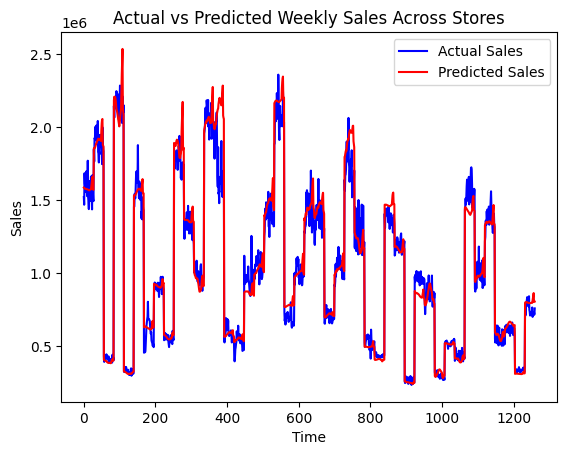

In [13]:
# Plot the actual vs predicted sales
plt.plot(all_actual_sales, color='blue', label='Actual Sales')
plt.plot(all_predicted_sales, color='red', label='Predicted Sales')
plt.title('Actual vs Predicted Weekly Sales Across Stores')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.show()

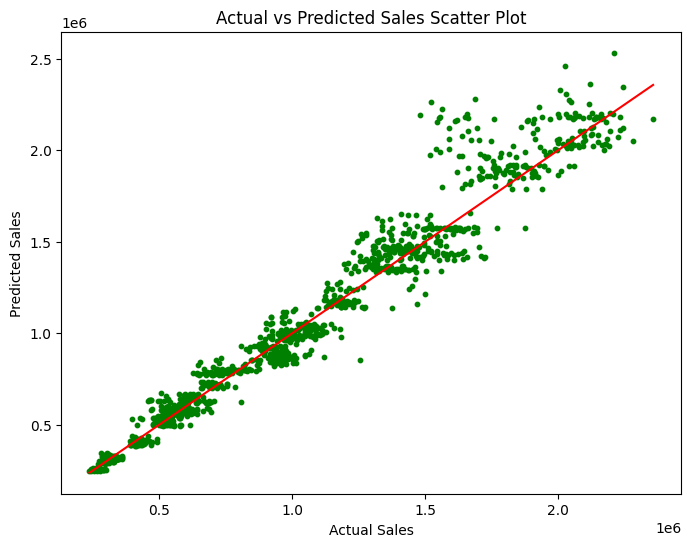

In [14]:
plt.figure(figsize=(8, 6))
plt.scatter(all_actual_sales, all_predicted_sales, color='green', s=10)
plt.plot([min(all_actual_sales), max(all_actual_sales)], [min(all_actual_sales), max(all_actual_sales)], color='red')
plt.title('Actual vs Predicted Sales Scatter Plot')
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.show()


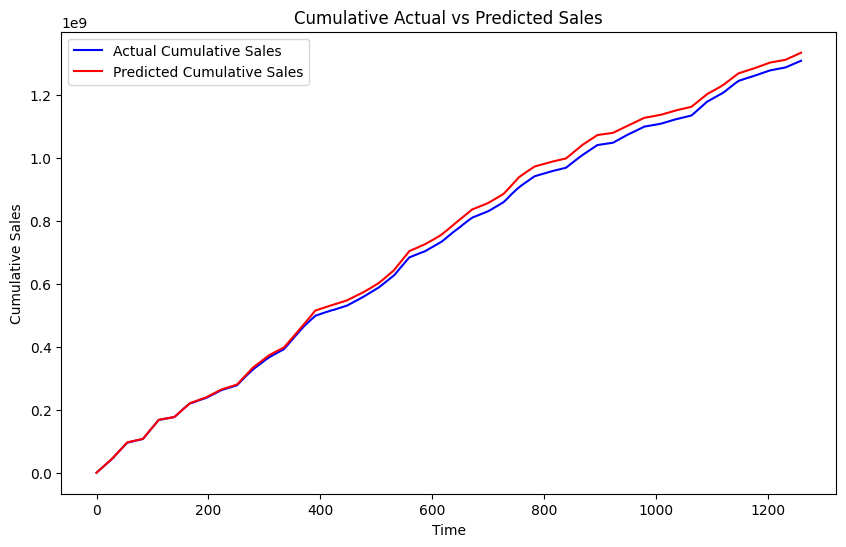

In [15]:
# Calculate cumulative sales
cumulative_actual = np.cumsum(all_actual_sales)
cumulative_predicted = np.cumsum(all_predicted_sales)

plt.figure(figsize=(10, 6))
plt.plot(cumulative_actual, label='Actual Cumulative Sales', color='blue')
plt.plot(cumulative_predicted, label='Predicted Cumulative Sales', color='red')
plt.title('Cumulative Actual vs Predicted Sales')
plt.xlabel('Time')
plt.ylabel('Cumulative Sales')
plt.legend()
plt.show()
